# Занятие 11. Геоданные. Способы обработки и анализа
Для разбора материала желательно ознакомление с курсом на Kaggle: https://www.kaggle.com/learn/geospatial-analysis.
В качестве примера взяты данные и задания с демонстрационного экзамена 2022-года.

https://gis-lab.info/docs/geojson_ru.html
# Модуль 1. Парсинг и предобработка данных
## Введение
Вам предстоит разработать систему по выявлению опасных дорожных участков и предотвращению будущих дорожно-транспортных происшествий на территории регионов Российской Федерации. Данные по ДТП доступны для загрузки на странице https://dtp-stat.ru/opendata/ и представлены в формате .geojson по всем регионам.

В рамках Модуля 1 необходимо подготовить набор данных и произвести его предобработку для дальнейшего исследования и построения моделей обучения.

## 1.1 Парсинг данных
На основе полученных geojson файлов необходимо построить исходный набор данных по дорожно-транспортным происшествиям в России. 

In [1]:
# подгрузка необходимых для работы с данными модулей
import pandas as pd
import geopandas as gpd
import numpy as np

# подгрузка необходимых для визуализации данных модулей
import matplotlib.pyplot as plt
import seaborn as sns

# отключить предупреждения
import warnings
warnings.filterwarnings('ignore')

# модуль для работы с операционной системой
import os 
# путь до данных
PATH_TO_DATA = "data/regions/"

In [2]:
# получим имена всех файлов, которые лежат в PATH_TO_DATA
geo_data_files = os.listdir(PATH_TO_DATA)

Последовательное считывание геоджейсонов занимает много времени. Отличный способ сократить время загрузки данных - распараллелить загрузку отдельных файлов.

В python параллелизация за счёт потоков - бесполезная идея из-за встроенного в интерпретатор языка GIL (Global Interpretator Locker), поэтому параллелить можно (и нужно) на основе процессов. Суть: на вашем компьютере на разных ядрах будет запущено несколько экземпляров интерпретатора python, каждый из которых будет считывать отдельный файл. 

In [3]:
%%time
from multiprocessing import Pool
from time import time

# функция для считывания в отдельном процессе 
# отдельного файлал
def read_geojson(geojson):
    return gpd.read_file(PATH_TO_DATA+geojson)

# количество процессов - берется в количестве ядер вашего компьютера
NUM_PROCESS = os.cpu_count()

# Pool - менеджер, управляющий этими потоками
with Pool(processes=NUM_PROCESS) as p:
    geo_data = p.map(read_geojson, geo_data_files, chunksize=3)

all_regions = gpd.GeoDataFrame(pd.concat(list(geo_data), ignore_index=True))
all_regions.head(5)

CPU times: user 11.4 s, sys: 3.46 s, total: 14.9 s
Wall time: 39.3 s


,id,gibdd_id,point,participant_categories,severity,region,parent_region,datetime,address,participants_count,...,category,light,nearby,weather,road_conditions,vehicles,participants,tags,scheme,geometry
0,2382261,181023153,"{'lat': 52.145556, 'long': 116.167778}",[Все участники],С погибшими,Шилкинский район,Забайкальский край,2015-10-29 16:15:00,Р-297 Амур Чита - Невер - Свободный - Архара -...,2,...,Опрокидывание,Светлое время суток,[ ],[Ясно],"[Недостатки зимнего содержания, Со снежным нак...","[ { ""brand"": ""УАЗ"", ""model"": ""Прочие модели УА...",[ ],[Дорожно-транспортные происшествия],600,POINT (116.16778 52.14556)
1,2382271,179627141,"{'lat': 52.008889, 'long': 115.787778}","[Мотоциклисты, Все участники]",Легкий,Шилкинский район,Забайкальский край,2015-10-12 23:00:00,"ПРОЧИЕ ДОРОГИ ЗАБАЙКАЛЬСКОГО КРАЯ, 2 км",1,...,Опрокидывание,"В темное время суток, освещение отсутствует",[ ],[Ясно],"[Сухое, Неровное покрытие]","[ { ""brand"": ""ИЖ"", ""model"": ""Планета"", ""color""...",[ ],[Дорожно-транспортные происшествия],610,POINT (115.78778 52.00889)
2,2382269,180019803,"{'lat': 51.278333, 'long': 116.034167}","[Мотоциклисты, Все участники]",Тяжёлый,Шилкинский район,Забайкальский край,2015-10-18 00:20:00,"г Шилка, ул Ленина, 84",2,...,Столкновение,"В темное время суток, освещение включено","[ ""Многоквартирные жилые дома"", ""Нерегулируемы...",[Ясно],[Сухое],"[ { ""brand"": ""YAMAHA"", ""model"": ""VMX 1200"", ""c...",[ ],[Дорожно-транспортные происшествия],140,POINT (116.03417 51.27833)
3,2382260,178759316,"{'lat': 51.540833, 'long': 116.145556}","[Дети, Мотоциклисты, Все участники]",Тяжёлый,Шилкинский район,Забайкальский край,2015-10-03 21:30:00,"пгт Холбон, ул Имени Маршала Жукова Г.К., 10",2,...,Столкновение,"В темное время суток, освещение включено","[ ""Жилые дома индивидуальной застройки"", ""Нере...",[Ясно],"[Сухое, Отсутствие, плохая различимость горизо...","[ { ""brand"": ""TOYOTA"", ""model"": ""Kluger"", ""col...",[ ],"[Дорожно-транспортные происшествия, ДТП и пост...",430,POINT (116.14556 51.54083)
4,2377355,208392988,"{'lat': 51.820447, 'long': 115.915289}",[Все участники],Тяжёлый,Шилкинский район,Забайкальский край,2018-01-01 07:00:00,"МОГОЙТУЙ - СРЕТЕНСК - ОЛОЧИ, 113 км",1,...,Опрокидывание,"В темное время суток, освещение отсутствует",[ ],[Пасмурно],[Сухое],"[ { ""brand"": ""HONDA"", ""model"": ""Odyssey"", ""col...",[ ],[Дорожно-транспортные происшествия],610,POINT (115.91529 51.82045)


In [4]:
# убедимся, что объект действительно имеет тип GeoDataFrame
type(all_regions)

geopandas.geodataframe.GeoDataFrame

In [5]:
# сколько данных в получившемся наборе?
all_regions.shape

(1038495, 22)

In [6]:
all_regions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1038495 entries, 0 to 1038494
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id                      1038495 non-null  int64         
 1   gibdd_id                1038495 non-null  object        
 2   point                   1038495 non-null  object        
 3   participant_categories  1038495 non-null  object        
 4   severity                1038495 non-null  object        
 5   region                  1038495 non-null  object        
 6   parent_region           1038495 non-null  object        
 7   datetime                1038495 non-null  datetime64[ns]
 8   address                 994969 non-null   object        
 9   participants_count      1038495 non-null  int64         
 10  injured_count           1038495 non-null  int64         
 11  dead_count              1038495 non-null  int64         
 12  catego

## 1.2 Предобработка и выделение значимых атрибутов
Задача определения опасности дорожного участка или перекрёстка заключается в определении класса (кластера) - уровня опасности. Уровни опасности определяются произвольным образом, но так, чтобы в группу наиболее опасных участков, требующих срочных решений, должно попасть около 10% данных от каждого региона.

### 1.2.1 Обработка отсутствующих значений

#### Общий взгляд

In [7]:
# пропуски в данных в процентном соотношении
missings = pd.DataFrame(all_regions.isnull().sum() / all_regions.shape[0] * 100, 
                        columns=['% пропусков'])
missings

,% пропусков
id,0.000000
gibdd_id,0.000000
point,0.000000
participant_categories,0.000000
severity,0.000000
region,0.000000
parent_region,0.000000
datetime,0.000000
address,4.191258
participants_count,0.000000


Пропусков в данных немного, при этом атрибуты, имеющие невалидные значения, между собой взаимосвязаны: `geometry` - это атрибут с географическим положением объекта, `address` - то же самое, но в текстовом представлении, поэтому можно восстановить один атрибут с помощью другого.

#### Предлагаемый подход

Геоданные одновременно и усложняют, и упрощают задачу заполнения пропусков. С одной стороны, здесь могут не сработать привычные методы статистической обработки, с другой - мы имеем возможность восстанавливать данные, подтягивая их из внешних источников: из разных геокодеров, благо, что geopandas имеет специальные средства для этого.

Для начала попробуем восстановить атрибут `geometry`. Для этого преобразуем координаты из атрибута `point` в тип geometry.Point.

In [8]:
all_regions[['geometry', 'point']]

,geometry,point
0,POINT (116.16778 52.14556),"{'lat': 52.145556, 'long': 116.167778}"
1,POINT (115.78778 52.00889),"{'lat': 52.008889, 'long': 115.787778}"
2,POINT (116.03417 51.27833),"{'lat': 51.278333, 'long': 116.034167}"
3,POINT (116.14556 51.54083),"{'lat': 51.540833, 'long': 116.145556}"
4,POINT (115.91529 51.82045),"{'lat': 51.820447, 'long': 115.915289}"
...,...,...
1038490,POINT (48.29581 42.06041),"{'lat': 42.060405, 'long': 48.295813}"
1038491,POINT (48.27110 42.07530),"{'lat': 42.0753, 'long': 48.2711}"
1038492,POINT (48.29055 42.03935),"{'lat': 42.039349, 'long': 48.290555}"
1038493,POINT (48.28841 42.06945),"{'lat': 42.069446, 'long': 48.28841}"


Заметим, что координаты точек в атрибутах совпадают. Проверим, во всех ли записях атрибут `geometry` имеет объект класса Point.

In [9]:
all_regions[all_regions['geometry'].geom_type != 'Point']['geometry']

482        None
2380       None
3927       None
4873       None
6779       None
           ... 
1038152    None
1038169    None
1038173    None
1038195    None
1038388    None
Name: geometry, Length: 10737, dtype: geometry

In [10]:
all_regions[all_regions['geometry'].geom_type != 'Point']['geometry'] == None

482        True
2380       True
3927       True
4873       True
6779       True
           ... 
1038152    True
1038169    True
1038173    True
1038195    True
1038388    True
Name: geometry, Length: 10737, dtype: bool

In [11]:
all(all_regions[all_regions['geometry'].geom_type != 'Point']['geometry'] == None)

True

Атрибут `geometry` не во всех записях содержит данные типа Point - в некоторых просто отсутствует значение.

In [12]:
all_regions[all_regions['geometry'].geom_type != 'Point']['point']

482        {'lat': None, 'long': None}
2380       {'lat': None, 'long': None}
3927       {'lat': None, 'long': None}
4873       {'lat': None, 'long': None}
6779       {'lat': None, 'long': None}
                      ...             
1038152    {'lat': None, 'long': None}
1038169    {'lat': None, 'long': None}
1038173    {'lat': None, 'long': None}
1038195    {'lat': None, 'long': None}
1038388    {'lat': None, 'long': None}
Name: point, Length: 10737, dtype: object

Обратим внимание, что несмотря на то, что в атрибуте `point` нет пропусков, в нём есть невалидные значения, которые не помогают восстановить атрибут `geometry`. При этом стоит заметить, что невалидные значения в `point` и пропуски в `geometry` совпадают, поэтому эти записи невалидны в целом. Но можно попытаться восстановить данные при помощи <b>геокодирования</b> - поиска координат по текстовому описанию адреса.

In [13]:
all_regions[all_regions['geometry'].isnull()]['address']

482                                                      NaN
2380                     ДАРАСУН - ГОСГРАНИЦА  С МНР, 259 км
3927         Р-258 Байкал Иркутск - Улан-Удэ - Чита, 1070 км
4873                         пгт Шерловая Гора, ул 1 Мая, 10
6779                               г Чита, ул Недорезова, 55
                                 ...                        
1038152    г Дагестанские Огни, Р-217 Кавказ автомобильна...
1038169    г Дагестанские Огни, Р-217 Кавказ автомобильна...
1038173    г Дагестанские Огни, Р-217 Кавказ автомобильна...
1038195    г Дагестанские Огни, Р-217 Кавказ автомобильна...
1038388    г Дербент, Р-217 Кавказ автомобильная дорога М...
Name: address, Length: 10737, dtype: object

In [14]:
from geopandas.tools import geocode
loc = all_regions[all_regions['geometry'].isnull()]['address']
location = geocode(loc, provider='nominatim', user_agent="my-request")
location

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=%D0%90-361+%D0%BF%D0%BE%D0%B4%D1%8A%D0%B5%D0%B7%D0%B4%D0%BD%D0%B0%D1%8F+%D0%B4%D0%BE%D1%80%D0%BE%D0%B3%D0%B0+%D0%BE%D1%82+%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9+%D0%B4%D0%BE%D1%80%D0%BE%D0%B3%D0%B8+%D0%90-360+%D0%9B%D0%B5%D0%BD%D0%B0+%D0%BA+%D0%B3%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B5+%D1%81+%D0%9A%D0%B8%D1%82%D0%B0%D0%B9%D1%81%D0%BA%D0%BE%D0%B9+%D0%9D%D0%B0%D1%80%D0%BE%D0%B4%D0%BD%D0%BE%D0%B9+%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%BE%D0%B9%2C+12+%D0%BA%D0%BC&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

К сожалению, не получилось восстановить данные с помощью геокодирования. Поэтому принимается решение удалить записи, которые содержат пропуски в атрибуте `geometry`. Это повлечёт за собой удаление невалидных значений в атрибуте `point`.

In [15]:
all_regions.drop(index=all_regions[all_regions['geometry'].isnull()].index, inplace=True)

In [16]:
# посмотрим пропуски снова
all_regions.isnull().sum()/all_regions.shape[0] * 100

id                        0.000000
gibdd_id                  0.000000
point                     0.000000
participant_categories    0.000000
severity                  0.000000
region                    0.000000
parent_region             0.000000
datetime                  0.000000
address                   4.173453
participants_count        0.000000
injured_count             0.000000
dead_count                0.000000
category                  0.000000
light                     0.000000
nearby                    0.000000
weather                   0.000000
road_conditions           0.000000
vehicles                  0.000000
participants              0.000000
tags                      0.000000
scheme                    6.008613
geometry                  0.000000
dtype: float64

Заметим, что атрибут `address` не привносит новой информации, поскольку в наборе данных уже имеются сведения о местоположении дорожно-транспортного происшествия, адрес - это всего лишь текстовое представление геокоординат.

Атрибут `scheme` - это технические данные, которые содержат информацию о структуре geojson, но не о самом событии. Также к технической информации можно отнести атрибуты `gibdd_id` и `id`, они не несут информации о происшествии.

На основе этого принимается решение удалить атрибуты `address`, `scheme`, `gibdd_id` и `id` как малоинформативные.

In [17]:
all_regions.drop(columns=['address', 'scheme', 'gibdd_id', 'id'], inplace=True)

# остались ли пропущенные значения?
all_regions.isnull().sum()/all_regions.shape[0] * 100

point                     0.0
participant_categories    0.0
severity                  0.0
region                    0.0
parent_region             0.0
datetime                  0.0
participants_count        0.0
injured_count             0.0
dead_count                0.0
category                  0.0
light                     0.0
nearby                    0.0
weather                   0.0
road_conditions           0.0
vehicles                  0.0
participants              0.0
tags                      0.0
geometry                  0.0
dtype: float64

### 1.2.2 Поиск и обработка нечисловых признаков
Поскольку в данных больше не содержится пропущенных значений, а часть атрибутов приведена к числовому типу данных, отберём только те атрибуты, которые имеют тип данных `object`.

In [18]:
non_numeric_cols = all_regions.select_dtypes(include=['object']).columns
non_numeric_cols

Index(['point', 'participant_categories', 'severity', 'region',
       'parent_region', 'category', 'light', 'nearby', 'weather',
       'road_conditions', 'vehicles', 'participants', 'tags'],
      dtype='object')

С какого атрибута начать? Рассмотрим атрибут `participant_categories` более подробно. В нём нет пропущенных значений, но что содержится в этом признаке?

#### participant_categories

In [19]:
all_regions['participant_categories']

0                              [Все участники]
1                [Мотоциклисты, Все участники]
2                [Мотоциклисты, Все участники]
3          [Дети, Мотоциклисты, Все участники]
4                              [Все участники]
                          ...                 
1038490          [Мотоциклисты, Все участники]
1038491              [Пешеходы, Все участники]
1038492                        [Все участники]
1038493              [Пешеходы, Все участники]
1038494              [Пешеходы, Все участники]
Name: participant_categories, Length: 1027758, dtype: object

Атрибут хранит в качестве значений списки (lists), которые не является хешируемым типом данных, из-за чего не сможем посмотреть униикальные значения признака.

In [20]:
# соберу все значения со всех списков в атрибуте
# и найду уникальные среди них

all_values = list()
for participant_category in all_regions['participant_categories']:
    all_values += participant_category
all_unique_values = set(all_values)
all_unique_values

{'Велосипедисты',
 'Все участники',
 'Дети',
 'Мотоциклисты',
 'Общ. транспорт',
 'Пешеходы'}

Уникальных значений не так много, возможны два способа преобразования признака. Первый предполагает, что мы оставим только одно значение в атрибуте. Например, если в списке содержится одно значение "Все участники", то оставим её, если же есть два значения "Все участники" и "Мотоциклисты", то откинем первую категорию и оставим только "Мотоциклисты". Однако при таком подходе теряется информация, а сам признак перестаёт быть значимым. 

Другой подход предполагает выделение на основе этого атрибута новых 6. У нас будут новые атрибуты, которые содержат кодировку: 1 - категория указана, 0 - категория не указана. Таким образом получится добавить новые взаимосвязи, которые впоследствии могут внести вклад в модель.

Принимается решение о добавлении новых атрибутов.

In [21]:
for participant in all_unique_values:
    all_regions[f'participant_{participant}'] =\
        all_regions['participant_categories'].apply(lambda x: 1 if participant in x else 0)
    
# исходный атрибут можно за ненадобностью удалить
all_regions.drop(columns=['participant_categories'], inplace=True)

#### severity

In [22]:
all_regions['severity']

0          С погибшими
1               Легкий
2              Тяжёлый
3              Тяжёлый
4              Тяжёлый
              ...     
1038490    С погибшими
1038491        Тяжёлый
1038492        Тяжёлый
1038493         Легкий
1038494         Легкий
Name: severity, Length: 1027758, dtype: object

In [23]:
all_regions['severity'].unique()

array(['С погибшими', 'Легкий', 'Тяжёлый'], dtype=object)

Этот признак обладает маленькой <b>кардинальностью</b>, то есть в нём очень мало уникальных значений, причём их можно выстроить в соответствии со степенью тяжести нанесения урона: легкий -> тяжёлый -> с погибшими. Закодируем сразу эти значения, присвоив им метки:
* 10 - лёгкий;
* 100 - тяжёлый;
* 1000 - с погибшими.

In [24]:
def get_severity_code(severety):
    if severety == 'Легкий':
        return 10
    elif severety == 'Тяжёлый':
        return 100
    else:
        return 1000

all_regions['severity'] = all_regions['severity'].apply(lambda x: get_severity_code(x))
all_regions['severity'].unique()

array([1000,   10,  100])

#### category

In [25]:
all_regions['category']

0              Опрокидывание
1              Опрокидывание
2               Столкновение
3               Столкновение
4              Опрокидывание
                 ...        
1038490        Опрокидывание
1038491    Наезд на пешехода
1038492         Столкновение
1038493    Наезд на пешехода
1038494    Наезд на пешехода
Name: category, Length: 1027758, dtype: object

In [26]:
print(f"Уникальных значений: {len(all_regions['category'].unique())}")
all_regions['category'].unique()

Уникальных значений: 18


array(['Опрокидывание', 'Столкновение', 'Наезд на пешехода',
       'Наезд на препятствие', 'Съезд с дороги', 'Падение пассажира',
       'Наезд на животное', 'Наезд на гужевой транспорт',
       'Наезд на стоящее ТС', 'Наезд на велосипедиста', 'Иной вид ДТП',
       'Падение груза',
       'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ',
       'Отбрасывание предмета',
       'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность',
       'Наезд на внезапно возникшее препятствие',
       'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы',
       'Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.'],
      dtype=object)

Закодируем категории, задав каждой из них свою метку.

In [27]:
from sklearn.preprocessing import LabelEncoder
all_regions['category'] = LabelEncoder().fit_transform(all_regions['category'])
all_regions['category'].unique()

array([12, 16,  9, 10, 17, 15,  5,  4, 11,  2,  1, 14,  8, 13,  6,  3,  7,
        0])

#### light

In [28]:
all_regions['light']

0                                  Светлое время суток
1          В темное время суток, освещение отсутствует
2             В темное время суток, освещение включено
3             В темное время суток, освещение включено
4          В темное время суток, освещение отсутствует
                              ...                     
1038490                            Светлое время суток
1038491       В темное время суток, освещение включено
1038492                            Светлое время суток
1038493                            Светлое время суток
1038494                                        Сумерки
Name: light, Length: 1027758, dtype: object

In [29]:
all_regions['light'].unique()

array(['Светлое время суток',
       'В темное время суток, освещение отсутствует',
       'В темное время суток, освещение включено', 'Сумерки',
       'В темное время суток, освещение не включено', 'Не установлено'],
      dtype=object)

Значения атрибута хешируемые, но их можно выстроить в шкалу: <br>
не установлено -> светлое время суток -> сумерки -> в темное время суток, освещение включено -> в темное время суток, освещение выключено -> в темное время суток, освещение отсутствует. <br>
Расставим метки в соответствии с этой шкалой, придав самой негативной ситуации наибольший вес.

In [30]:
def get_light_code(light):
    if light == 'Не установлено':
        return 0
    elif light == 'Светлое время суток':
        return 2
    elif light == 'Сумерки':
        return 4
    elif light == 'В темное время суток, освещение включено':
        return 6
    elif light == 'В темное время суток, освещение не включено':
        return 8
    else:
        return 10

all_regions['light'] = all_regions['light'].apply(lambda x: get_light_code(x))
all_regions['light'].unique()

array([ 2, 10,  6,  4,  8,  0])

#### nearby

In [31]:
all_regions['nearby']

0                                                        [ ]
1                                                        [ ]
2          [ "Многоквартирные жилые дома", "Нерегулируемы...
3          [ "Жилые дома индивидуальной застройки", "Нере...
4                                                        [ ]
                                 ...                        
1038490    [Жилые дома индивидуальной застройки, Нерегули...
1038491    [Жилые дома индивидуальной застройки, Крупный ...
1038492    [Жилые дома индивидуальной застройки, Регулиру...
1038493    [Многоквартирные жилые дома, Внутридворовая те...
1038494    [Жилые дома индивидуальной застройки, Нерегули...
Name: nearby, Length: 1027758, dtype: object

In [32]:
# соберу все значения со всех списков в атрибуте
# и найду уникальные среди них

all_values = list()
for participant_category in all_regions['nearby']:
    all_values += participant_category
all_unique_values = set(all_values)
all_unique_values

{' ',
 '"',
 '(',
 ')',
 ',',
 '.',
 '/',
 ';',
 '[',
 '\\',
 ']',
 'А',
 'АЗС',
 'Автовокзал (автостанция)',
 'Автостоянка (не отделённая от проезжей части)',
 'Автостоянка (отделенная от проезжей части)',
 'Административные здания',
 'Аэропорт, ж/д вокзал (ж/д станция), речной или морской порт (пристань)',
 'В',
 'Внутридворовая территория',
 'Выезд с прилегающей территории',
 'Д',
 'Ж',
 'Жилые дома индивидуальной застройки',
 'З',
 'Зоны отдыха',
 'И',
 'Иная образовательная организация',
 'Иное образовательное учреждение',
 'Иной объект',
 'К',
 'Кладбище',
 'Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)',
 'Л',
 'Ледовая переправа',
 'Ледовая переправа (официально открытая и оборудованная);',
 'Ледовая переправа(официально открытая и оборудованная)',
 'Лечебные учреждения',
 'М',
 'Медицинские (лечебные) организации',
 'Место для перегона скота',
 'Многоквартирные жилые дома',
 'Мост',
 'Мост, эстакада, путепровод',
 'Н',
 'Надземн

Атрибут содержит много мусорных значений, однако полезные значения между собой равнозначны, их можно сделать дополнительными признаками.

In [33]:
for nearby_value in all_unique_values:
    if len(nearby_value) > 2:
        all_regions[f'nearby_{nearby_value}'] =\
            all_regions['nearby'].apply(lambda x: 1 if nearby_value in x else 0)

In [34]:
all_regions.drop(columns=['nearby'], inplace=True)

#### weather

In [35]:
all_regions['weather']

0              [Ясно]
1              [Ясно]
2              [Ясно]
3              [Ясно]
4          [Пасмурно]
              ...    
1038490        [Ясно]
1038491        [Ясно]
1038492        [Ясно]
1038493        [Ясно]
1038494        [Ясно]
Name: weather, Length: 1027758, dtype: object

In [36]:
all_values = list()
for participant_category in all_regions['weather']:
    all_values += participant_category
all_unique_values = set(all_values)
all_unique_values

{'Дождь',
 'Метель',
 'Пасмурно',
 'Снегопад',
 'Температура выше +30С',
 'Температура ниже -30С',
 'Туман',
 'Ураганный ветер',
 'Ясно'}



Отдельные природные явления могут коррелировать с частотой дорожно-транспортных происшествий. Добавим их как отдельные бинарные атрибуты.

In [37]:
for weather_value in all_unique_values:
    if len(weather_value) > 2:
        all_regions[f'weather_{weather_value}'] =\
            all_regions['weather'].apply(lambda x: 1 if weather_value in x else 0)
        
all_regions.drop(columns=['weather'], inplace=True)

#### road_conditions

In [38]:
all_regions['road_conditions']

0          [Недостатки зимнего содержания, Со снежным нак...
1                                 [Сухое, Неровное покрытие]
2                                                    [Сухое]
3          [Сухое, Отсутствие, плохая различимость горизо...
4                                                    [Сухое]
                                 ...                        
1038490    [Сухое, Неправильное применение, плохая видимо...
1038491                                              [Сухое]
1038492                                              [Сухое]
1038493                            [Сухое, Дефекты покрытия]
1038494                                              [Сухое]
Name: road_conditions, Length: 1027758, dtype: object

In [39]:
all_values = list()
for participant_category in all_regions['road_conditions']:
    all_values += participant_category
all_unique_values = set(all_values)
all_unique_values

{'Гололедица',
 'Дефекты покрытия',
 'Загрязненное',
 'Залитое (покрытое) водой',
 'Заснеженное',
 'Иные недостатки',
 'Мокрое',
 'Нарушения в размещении наружной рекламы',
 'Не установлено',
 'Недостатки зимнего содержания',
 'Недостаточное освещение',
 'Неисправное освещение',
 'Неисправность светофора',
 'Неправильное применение, плохая видимость дорожных знаков',
 'Неровное покрытие',
 'Несоответствие дорожных ограждений предъявляемым требованиям',
 'Несоответствие железнодорожного переезда предъявляемым требованиям',
 'Несоответствие люков смотровых колодцев и ливневой канализации предъявляемым требованиям',
 'Неудовлетворительное состояние обочин',
 'Неудовлетворительное состояние разделительной полосы',
 'Низкие сцепные качества покрытия',
 'Обработанное противогололедными материалами',
 'Ограничение видимости',
 'Отклонение верха головки рельса трамвайных (железнодорожных) путей, расположенных в пределах проезжей части, относительно покрытия, более чем на 2,0 см',
 'Отсутствие 

In [40]:
for road_value in all_unique_values:
    if road_value != 'Не установлено':
        all_regions[f'road_{road_value}'] =\
            all_regions['road_conditions'].apply(lambda x: 1 if road_value in x else 0)
all_regions.drop(columns=['road_conditions'], inplace=True)

#### vehicles

In [41]:
all_regions['vehicles']

0          [ { "brand": "УАЗ", "model": "Прочие модели УА...
1          [ { "brand": "ИЖ", "model": "Планета", "color"...
2          [ { "brand": "YAMAHA", "model": "VMX 1200", "c...
3          [ { "brand": "TOYOTA", "model": "Kluger", "col...
4          [ { "brand": "HONDA", "model": "Odyssey", "col...
                                 ...                        
1038490    [ { "brand": "Прочие марки мотоциклов", "model...
1038491    [ { "brand": "ВАЗ", "model": " Нива  ВАЗ-2121 ...
1038492    [ { "brand": "ГАЗ", "model": "3221  Газель , 3...
1038493    [ { "brand": "HYUNDAI", "model": "Прочие модел...
1038494    [ { "brand": "ВАЗ", "model": "Kalina", "color"...
Name: vehicles, Length: 1027758, dtype: object

In [42]:
all_regions['vehicles'][0]

'[ { "brand": "УАЗ", "model": "Прочие модели УАЗ", "color": "Зеленый", "year": 2006, "category": "Е-класс (высший средний, бизнес-класс) до 4,9 м", "participants": [ { "health_status": "Скончался на месте ДТП по прибытию скорой медицинской помощи, но до транспортировки в медицинское учреждение", "role": "Пассажир", "gender": "Мужской", "years_of_driving_experience": null, "violations": [ "Нарушение правил применения ремней безопасности пассажиром" ] }, { "health_status": "Не пострадал", "role": "Водитель", "gender": "Мужской", "years_of_driving_experience": 5, "violations": [ "Несоответствие скорости конкретным условиям движения", "Нарушение водителем правил применения ремней безопасности (ставится в случае, когда не пристегнут пассажир)" ] } ] } ]'

Фактически в этом атрибуте содержится информация об автомобиле и водителе. Однако данные, которые там содержатся, могут не влиять на работу целевой модели, поскольку марка и стаж водителя мало что могут сказать про конкретное место аварии. И даже год выпуска автомобиля, с помощью которого теоретически можно было бы вычислить возраст автомобиля, не поможет описать место аварии и возможные проблемы.

Принимается решение избавиться от этого признака.

In [43]:
all_regions.drop(columns=['vehicles'], inplace=True)

#### participants

In [44]:
all_regions['participants']

0                                                        [ ]
1                                                        [ ]
2                                                        [ ]
3                                                        [ ]
4                                                        [ ]
                                 ...                        
1038490                                                  [ ]
1038491    [ { "health_status": "Раненый, находящийся (на...
1038492                                                  [ ]
1038493    [ { "health_status": "Раненый, находящийся (на...
1038494    [ { "health_status": "Раненый, находящийся (на...
Name: participants, Length: 1027758, dtype: object

In [45]:
all_regions['participants'][1038493]

'[ { "health_status": "Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара", "role": "Пешеход", "gender": "Женский", "violations": [ ] } ]'

Атрибут, аналогичный предыдущему, однако здесь содержатся данные о пострадавшем участнике аварии. Эти данные также не описывают сам дорожный участок, а говорят о последствиях происшествия.

In [46]:
all_regions.drop(columns=['participants'], inplace=True)

#### tags

In [47]:
all_regions['tags']

0                        [Дорожно-транспортные происшествия]
1                        [Дорожно-транспортные происшествия]
2                        [Дорожно-транспортные происшествия]
3          [Дорожно-транспортные происшествия, ДТП и пост...
4                        [Дорожно-транспортные происшествия]
                                 ...                        
1038490                  [Дорожно-транспортные происшествия]
1038491                  [Дорожно-транспортные происшествия]
1038492                  [Дорожно-транспортные происшествия]
1038493                  [Дорожно-транспортные происшествия]
1038494                  [Дорожно-транспортные происшествия]
Name: tags, Length: 1027758, dtype: object

In [48]:
all_values = list()
for participant_category in all_regions['tags']:
    all_values += participant_category
all_unique_values = set(all_values)
all_unique_values

{'ДТП и пострадавшие дети в возрасте до 16 лет',
 'ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов',
 'Дорожно-транспортные происшествия'}

Ещё один технический атрибут, избавимся от него.

In [49]:
all_regions.drop(columns=['tags'], inplace=True)

У нас остались атрибуты, связанные с регионом и местом положения участка. Оставлю их как вспомогательные для следующих этапов.

#### parent_region и region 
Наши данные привязаны к регионам и меньшим территориальным единицам внутри них, однако разрабатываемая система должна распознавать опасные дорожные участки вне привязки к регионам, поэтому признак region можно удалить из выборки, а атрибут parent_region оставить для дальнейшей работы и конструирования новых признаков.

In [50]:
all_regions.drop(columns=['region'], inplace=True)

#### point
На всякий случай, разделим этот атрибут на два новых: longitude и latitude, содержащих широту и долоту соответсвтенно.

In [51]:
lats, longs = list(), list()
for coords in all_regions['point']:
    lats.append(coords['lat'])
    longs.append(coords['long'])


all_regions['lat'], all_regions['long'] = lats, longs
all_regions.drop(columns=['point'], inplace=True)
all_regions[['lat', 'long']]

,lat,long
0,52.145556,116.167778
1,52.008889,115.787778
2,51.278333,116.034167
3,51.540833,116.145556
4,51.820447,115.915289
...,...,...
1038490,42.060405,48.295813
1038491,42.075300,48.271100
1038492,42.039349,48.290555
1038493,42.069446,48.288410


Сами по себе координаты широты и долготы бесполезны, однако мы можем попробовать сгрупировать их, выделив какие-то области на карте, тем самым получив новый признак.

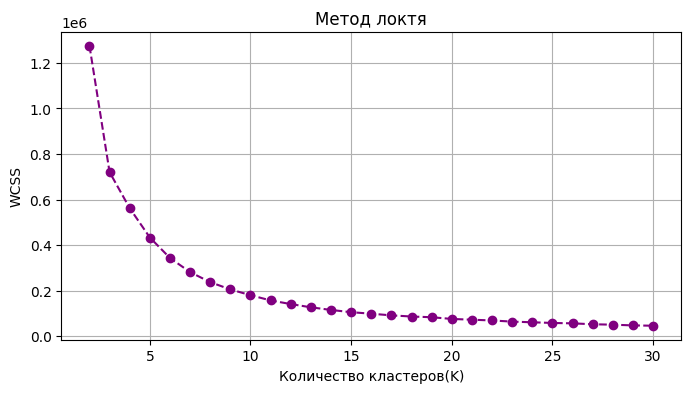

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
coords = all_regions[['lat', 'long']]
coords_scaled = StandardScaler().fit_transform(coords)

inertia = [] 
max_clusters = 30  
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=2023)
    kmeans.fit(coords_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, max_clusters + 1), inertia, marker='o', linestyle='--', color='purple')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров(K)')
plt.ylabel('WCSS')
plt.grid()
plt.show();

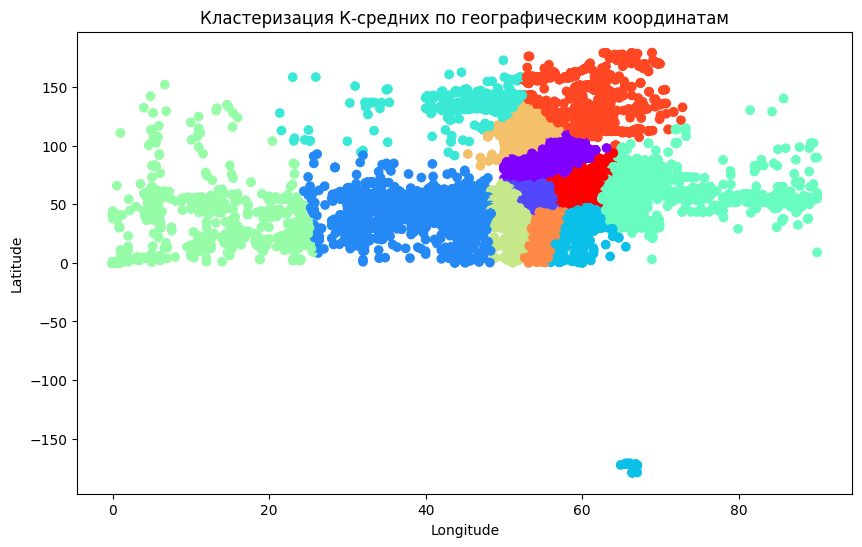

In [53]:
k = 12
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(coords_scaled)

all_regions['cluster_LatLng'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(all_regions['lat'], all_regions['long'], 
            c=all_regions['cluster_LatLng'], cmap='rainbow')
plt.title('Кластеризация К-средних по географическим координатам')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();

In [54]:
all_regions.drop(columns=['lat', 'long'], inplace=True)

### 1.2.3 Временные признаки
В наборе данных присутствует атрибут `datetime`, который сам по себе довольно часто не является информативным. Однако на его основе можно получить дополнительные данные, которые внесут в данные новые зависимости: месяц, день, час, когда случилось дорожно-транспортное происшествие. Такие признаки могут иметь **сезонность**.

Иногда сезонность, или какую-то повторяемость наблюдений, может иметь даже день недели. Выделим новые атрибуты, которые теоретически могут внести информацию о сезонности: час происшествия, день месяца, месяц, день недели.

In [55]:
# выделим дополнительные атрибуты
all_regions['hour'] = all_regions['datetime'].dt.hour
all_regions['day'] = all_regions['datetime'].dt.day
all_regions['month'] = all_regions['datetime'].dt.month
all_regions['day_of_week'] = all_regions['datetime'].dt.weekday

## 1.3 Описание структуры набора данных

In [56]:
all_regions.shape

(1027758, 130)

В результате предобработки получился набор данных, имеющий 1 027 758 записей и 130 атрибутов. Список атрибутов представлен ниже.

In [57]:
for col in all_regions.columns:
    print(col)

severity
parent_region
datetime
participants_count
injured_count
dead_count
category
light
geometry
participant_Мотоциклисты
participant_Общ. транспорт
participant_Велосипедисты
participant_Все участники
participant_Дети
participant_Пешеходы
nearby_Регулируемый ж/д переезд без дежурного
nearby_Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения
nearby_Ледовая переправа(официально открытая и оборудованная)
nearby_Тротуар, пешеходная дорожка
nearby_Мост, эстакада, путепровод
nearby_Нерегулируемый ж/д переезд
nearby_Место для перегона скота
nearby_Остановка общественного транспорта
nearby_Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)
nearby_Регулируемый ж/д переезд с дежурным
nearby_Остановка трамвая
nearby_Иной объект
nearby_Ледовая переправа
nearby_Объект торговли, общественного питания на автодороге вне НП
nearby_Территориальное подразделение МВД Ро

На текущий момент имеются следующие атрибуты:
* `severity` $-$ категориальный признак, обозначающий степень нанесённого урона жертвам ДТП, в соответствии с кодировкой, описанной выше, имеет следующие значения: 10 - легкий урон, 100 - тяжёлый урон, 1000 - в ДТП погибли люди, будет использоваться для выделения новых признаков, но не для обучения;
* `parent_region` $-$ категориальный признак, содержащий данные о регионе РФ, где произошло ДТП, в строковом представлении, при обучении участвовать не будет, оставлен для выделения новых атрибутов;
* `datetime`, `hour`, `day`, `month`, `day_of_week` $-$ временные признаки, содержащий сведения о дате и времени ДТП, оставлены для исследования на сезонность;
* `participants_count`, `injured_count`, `dead_count` $-$ количественные признаки, которые содержат информацию о количестве участников ДТП, количестве пострадавших и количестве погибших соответственно; данные представлены в целочисленном виде, будут использованы, вероятно, для обучения модели, а также для выделения новых признаков;
* `light` $-$ категориальный признак, содержащий данные о степени освещённости дорожного участка, данные закодированы, обозначения категорий описаны выше в пункте 1.2.1;
* `geometry`, `cluster_LatLng` $-$ атрибуты, содержащие сведения о географическом местоположении дорожного участка; атрибут `geometry` вспомогательный, выступает в качестве альтернативы удалённому атрибуту `address`, будет использован для выделения новых признаков; атрибуты `lat` и `long` $-$ основные, вероятно, будут использоваться для построения модели;
* атрибуты, имеющие префикс `participant_` $-$ группа бинарных признаков, содержащих информацию о категории пострадавших в ДТП, 1 - категория указана, 0 - категория не представлена;
* `category` $-$ категориальный признак, соодержащий информацию о виде ДТП;
* группа атрибутов, имеющих префикс `nearby_` $-$ бинарные признаки, отвечающие за сведения о месте ДТП;
* группа атрибутов, имеющих префикс `road_` $-$ бинарные признаки, отвечающие за тип состояния дорожного покрытия на момент происшествия аварии.

При проектировании системы, которая должна выявлять потенциально опасные дорожные участки и перекрёстки, нужно учитывать, что эта система должна в идеале выявлять опасные участки до наступления ДТП, а не после того, как на этом участке случится несколько ДТП. На основе этой идеи делается предположение, что полезными будут признаки, отвечающие о состоянии дорожного покрытия, говорящие о погодных условиях и месте происшествия.

In [58]:
# удалим только признаки, которые описывают ДТП, но не участок дороги
# оставим на этом этапе только те, которые пригодятся для конструирования целевого признака

all_regions.drop(columns=['category', 'participants_count', 
                          'injured_count', 'dead_count'] \
              + [cat for cat in all_regions.columns if cat.startswith('participant_')], 
              inplace=True)

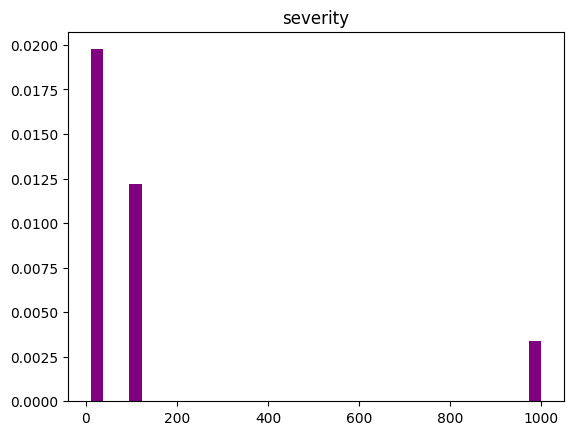

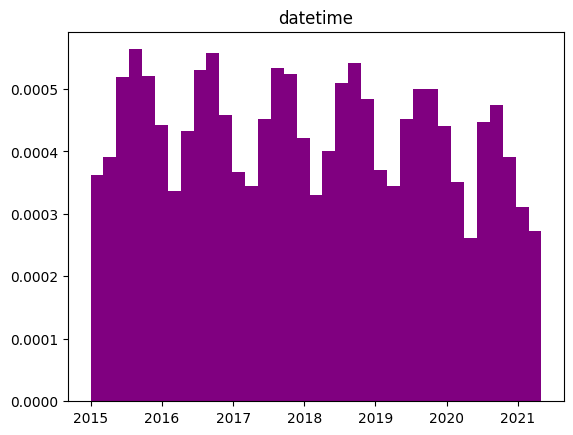

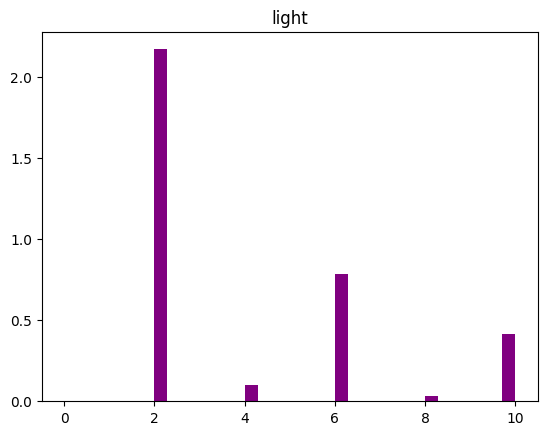

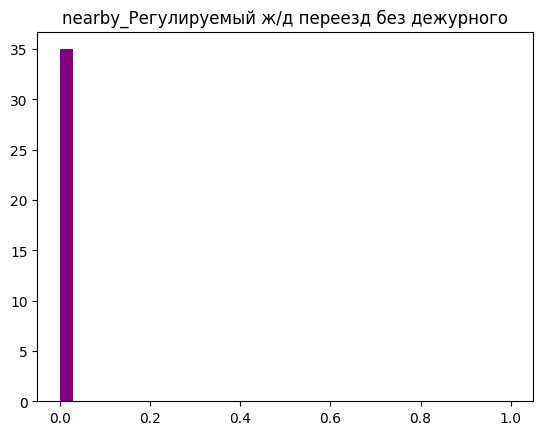

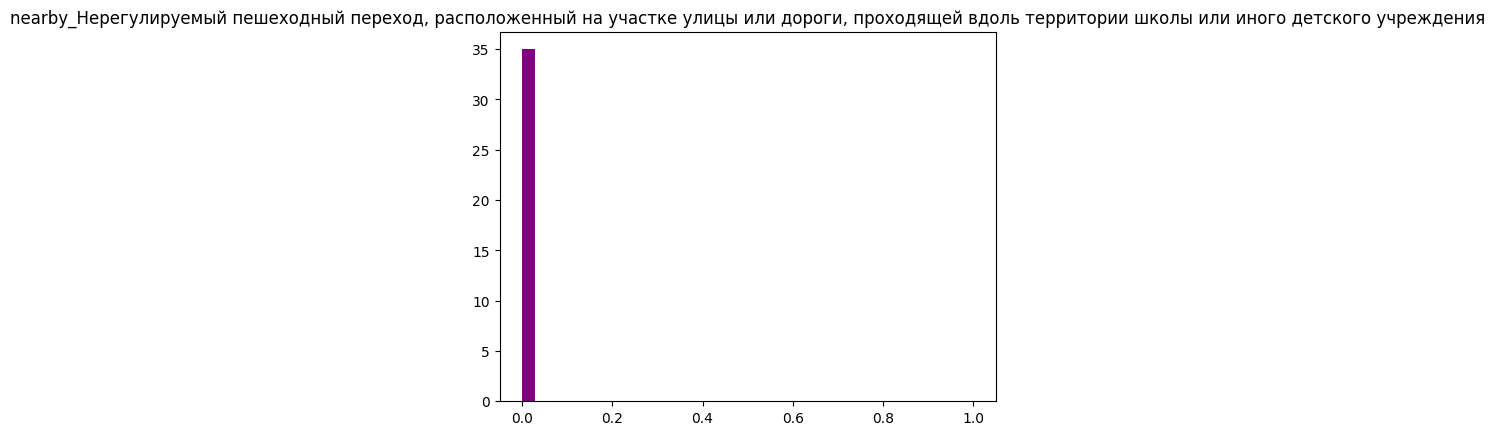

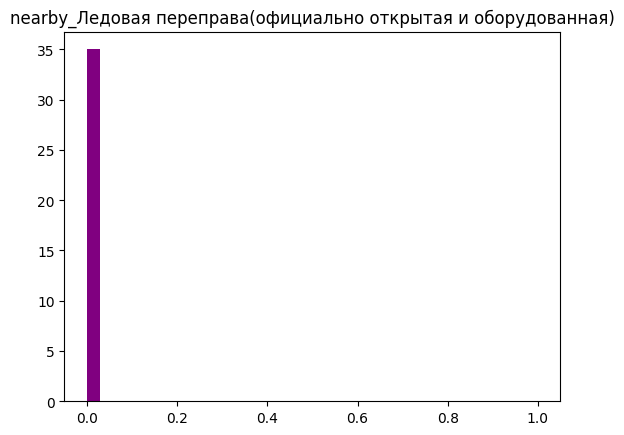

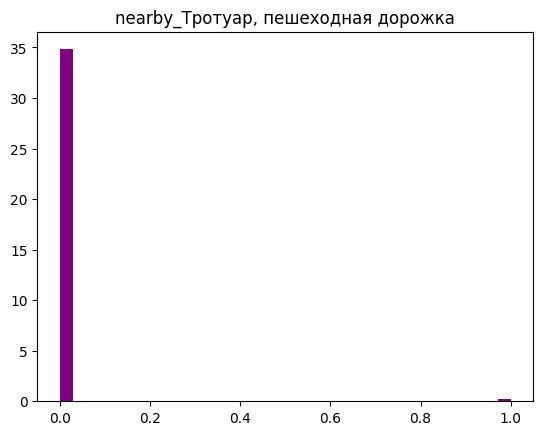

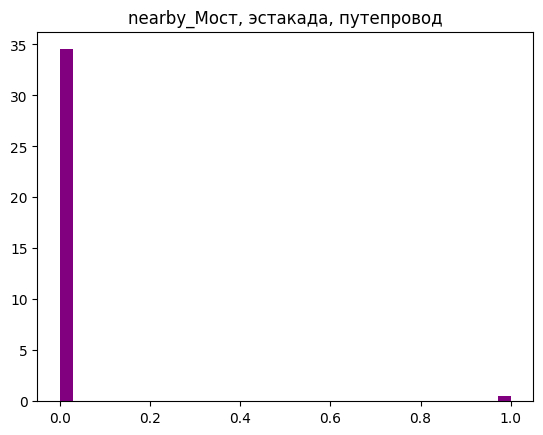

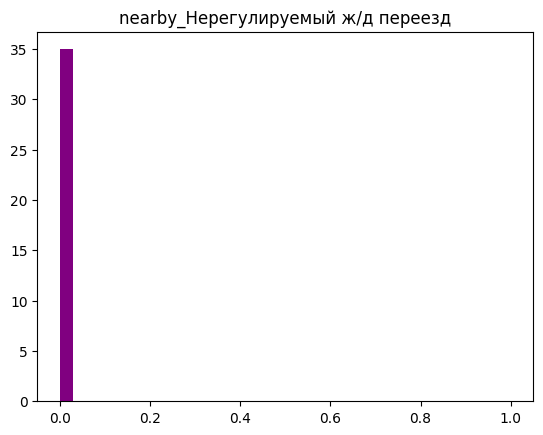

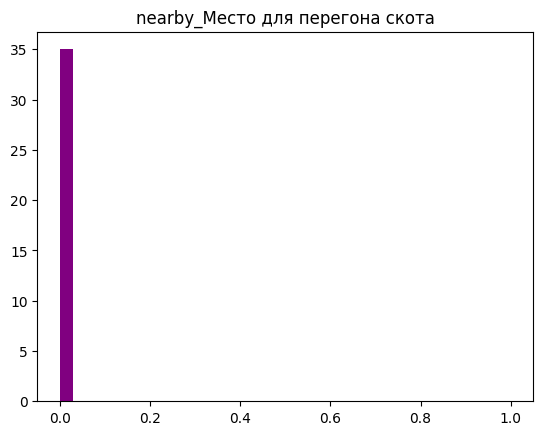

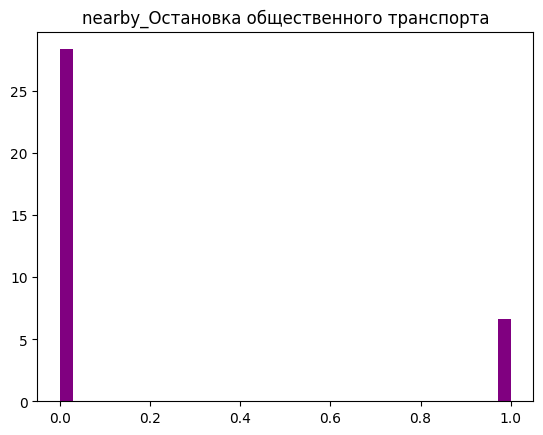

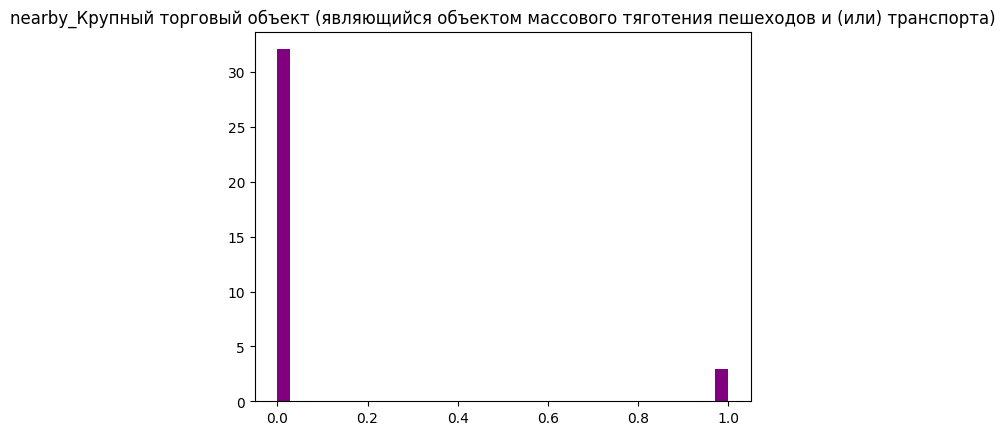

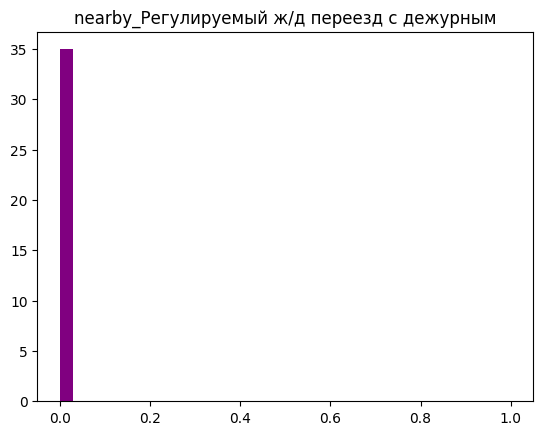

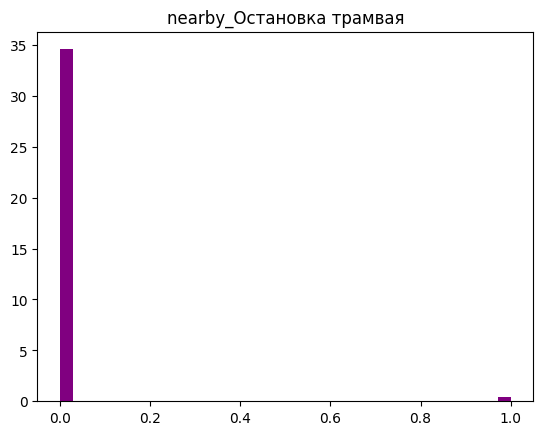

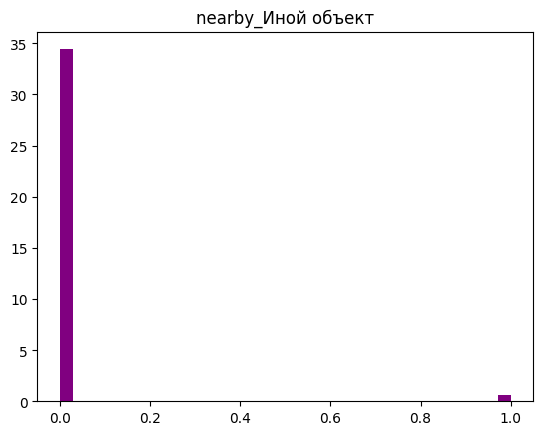

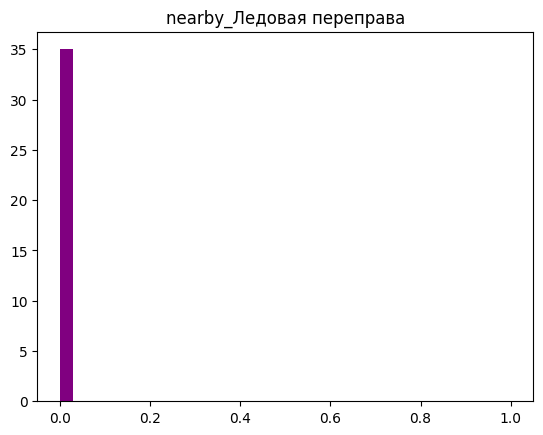

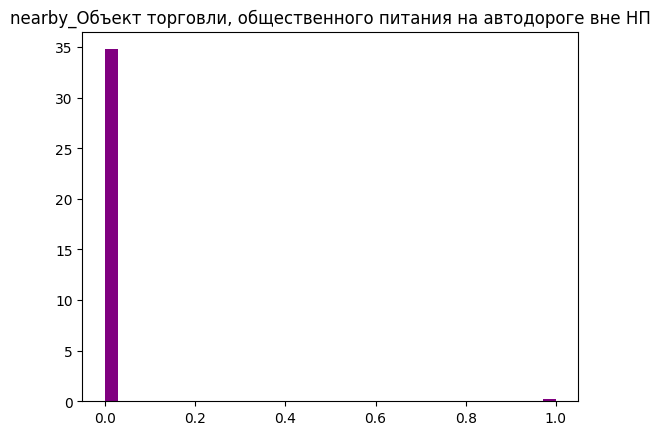

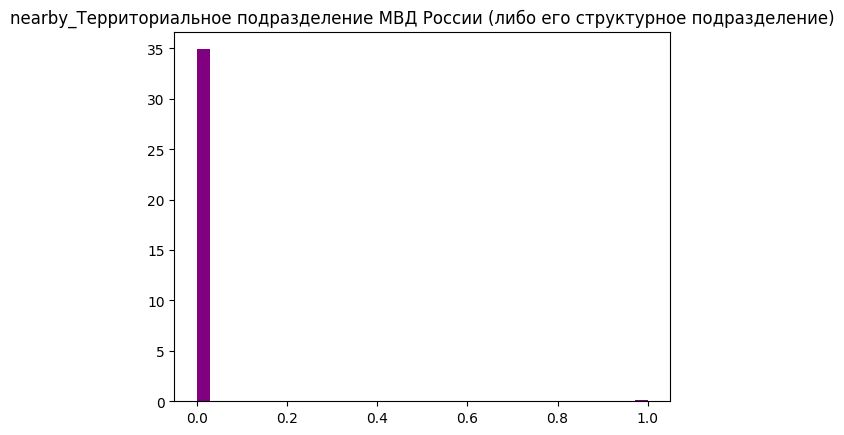

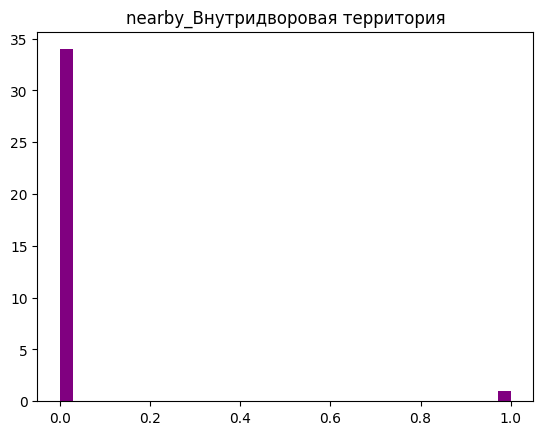

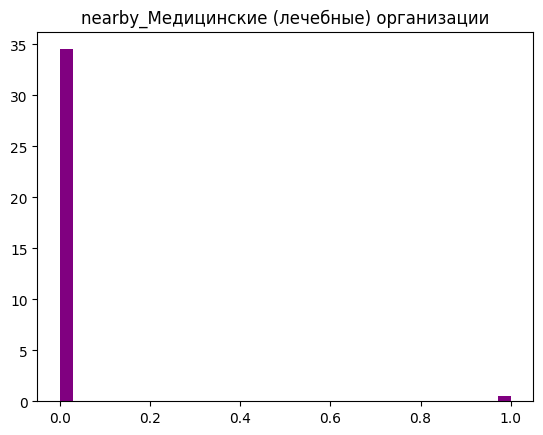

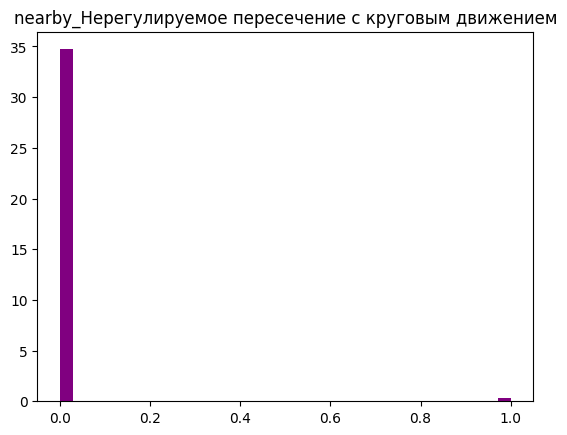

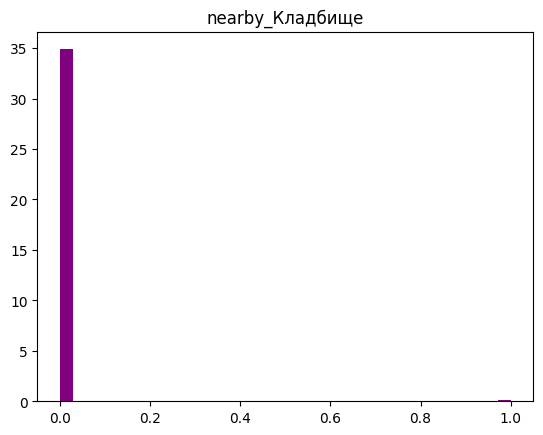

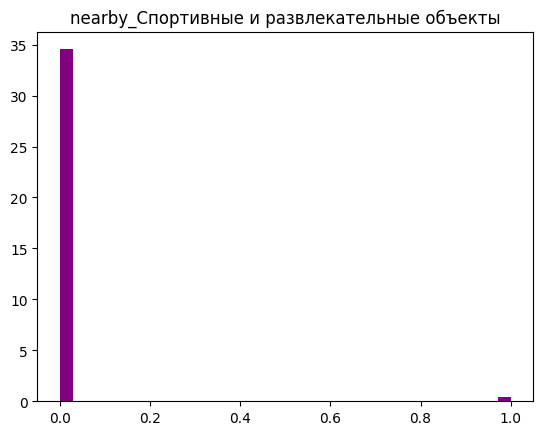

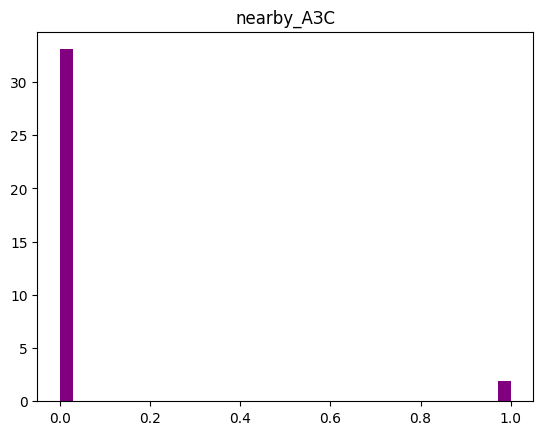

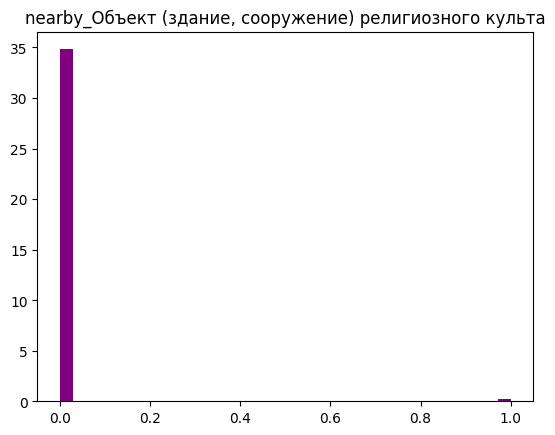

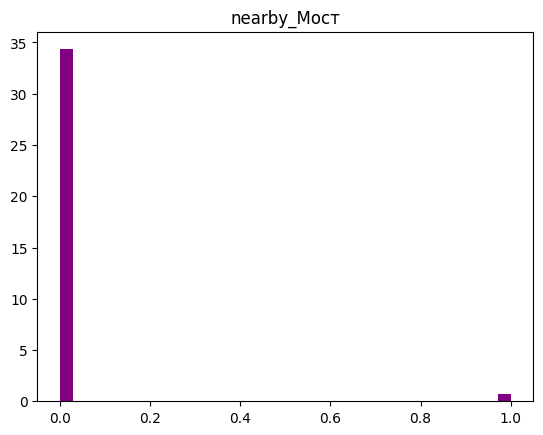

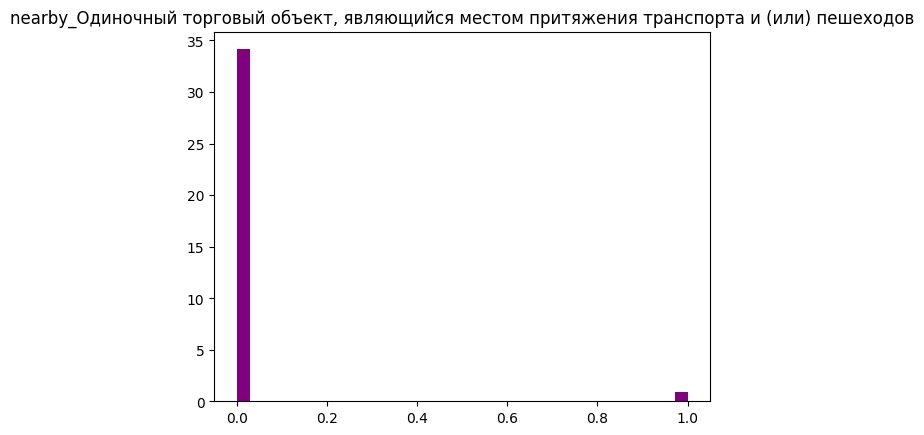

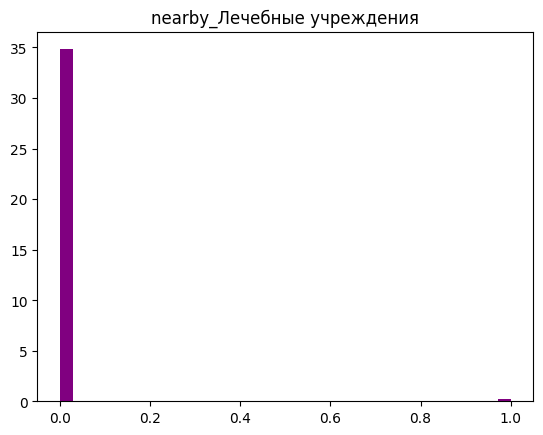

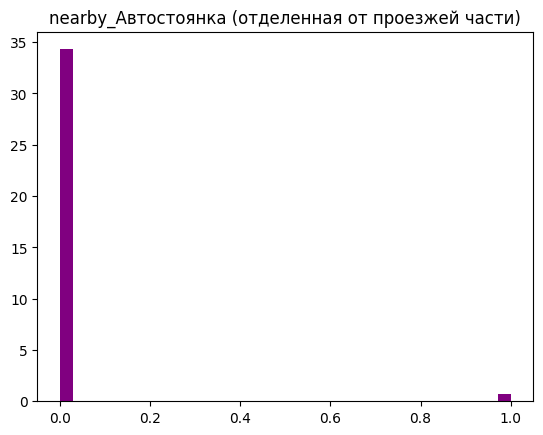

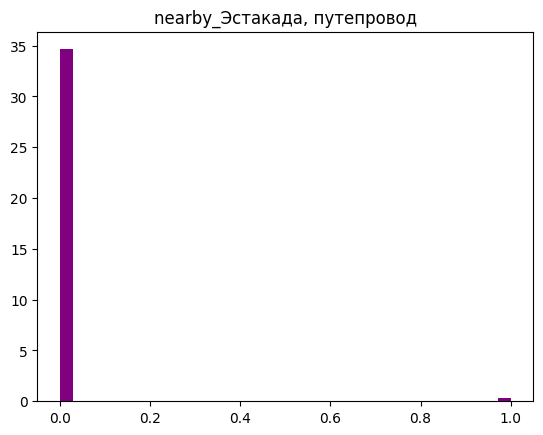

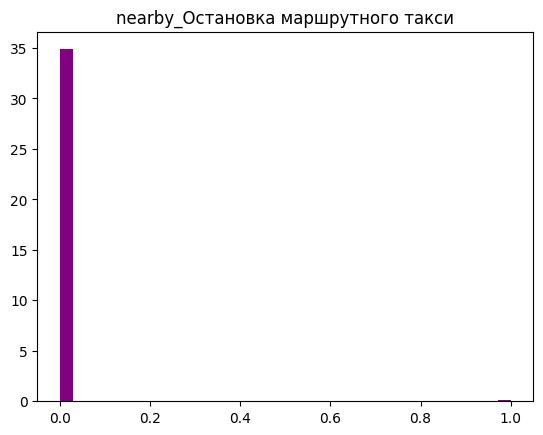

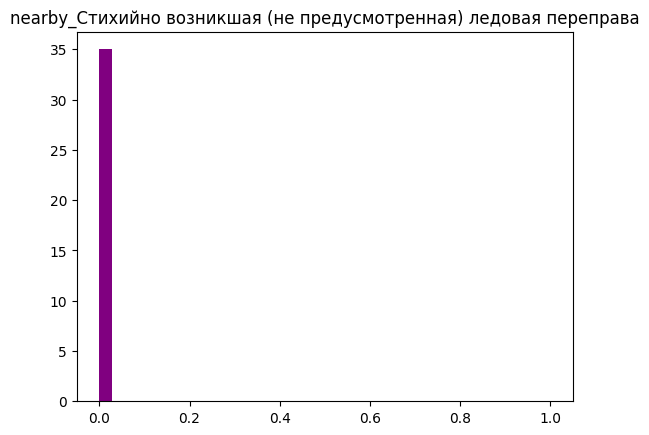

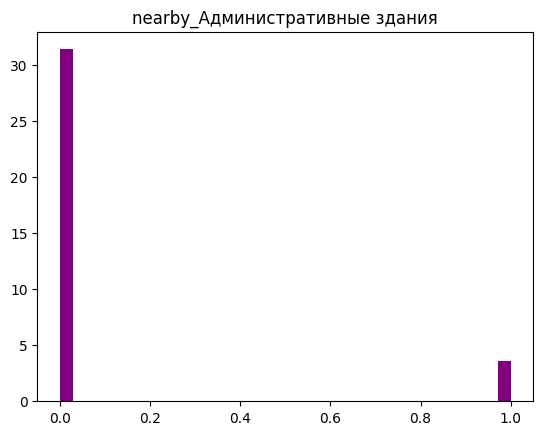

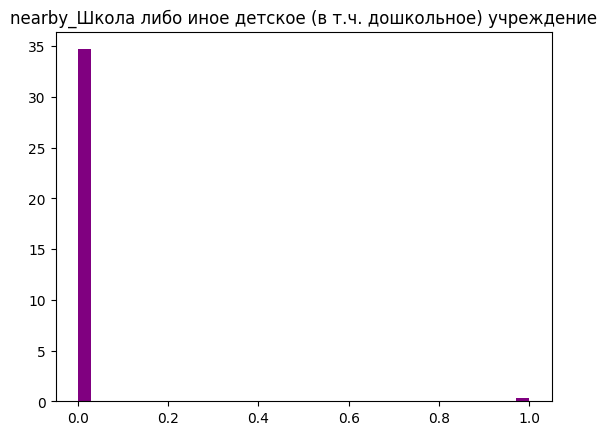

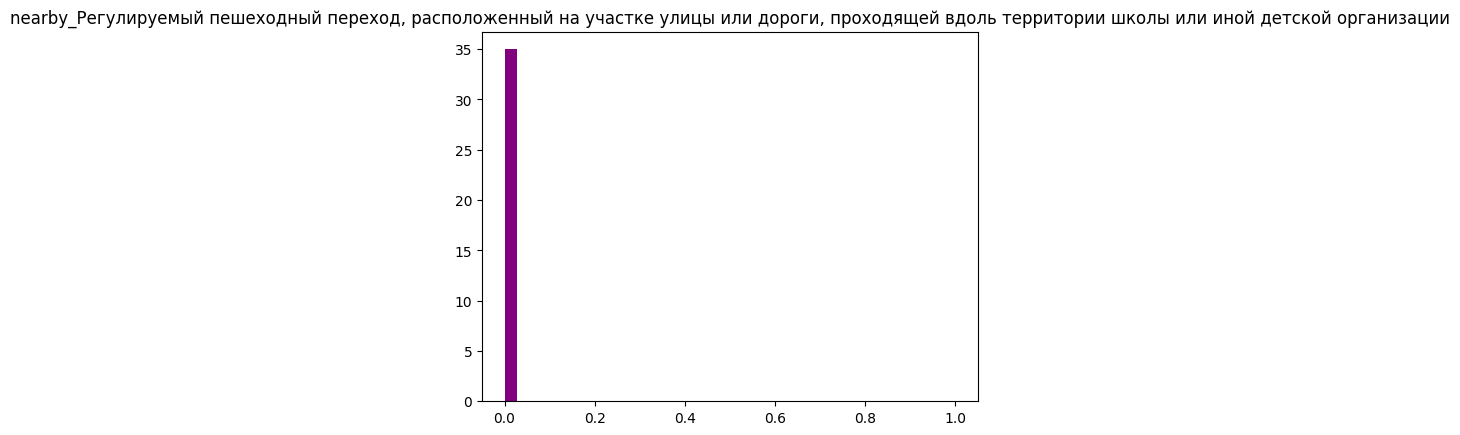

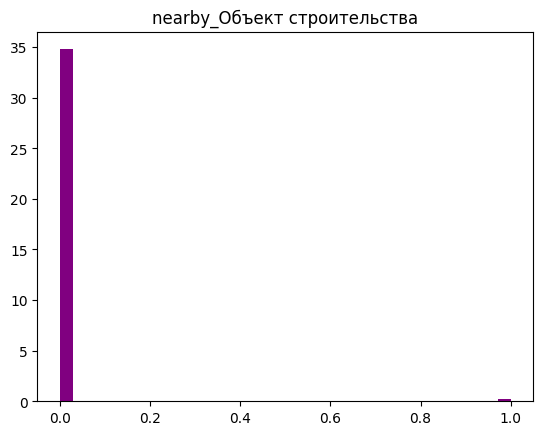

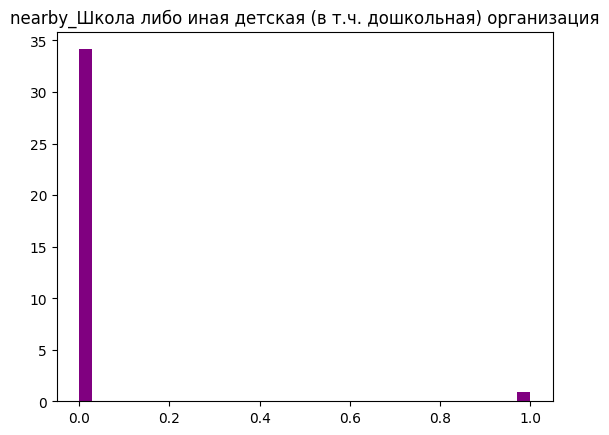

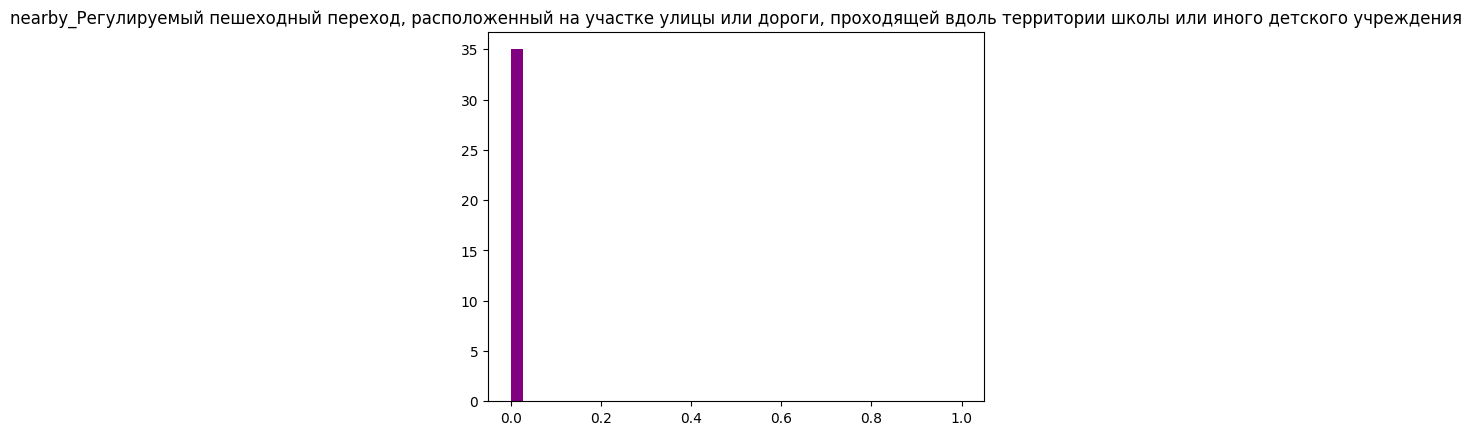

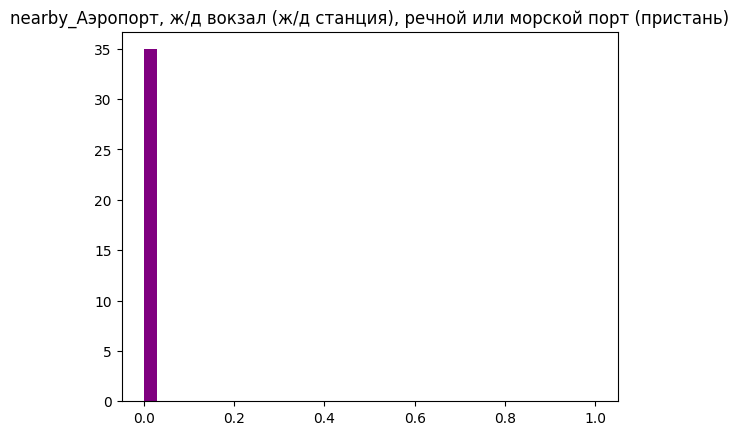

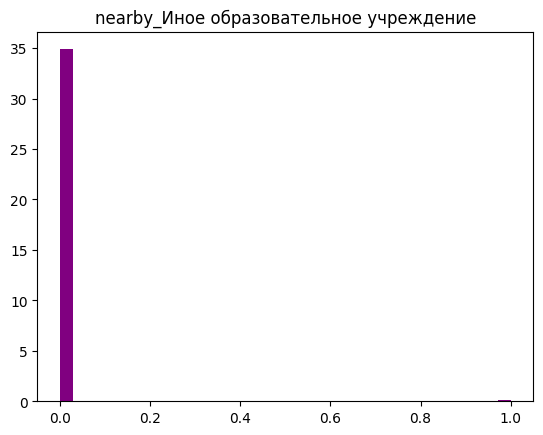

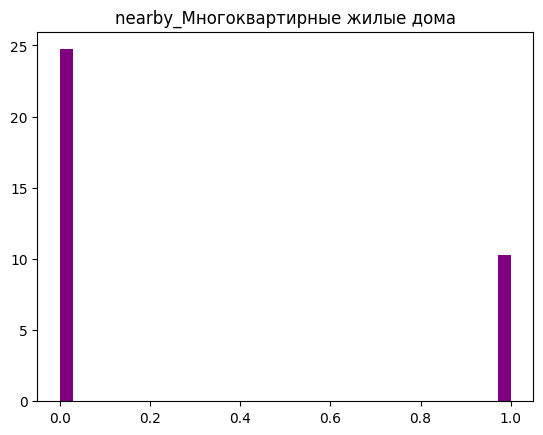

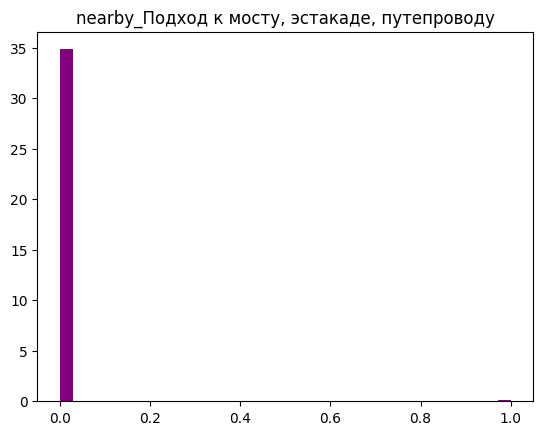

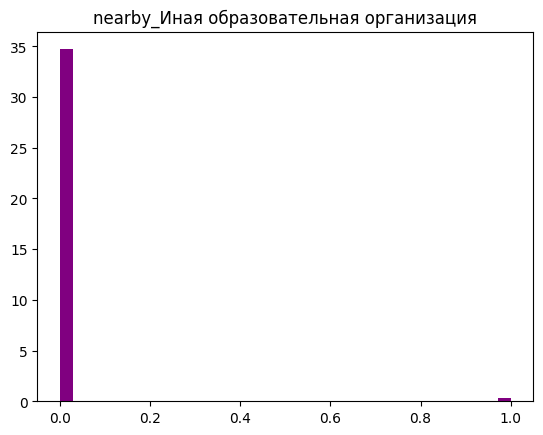

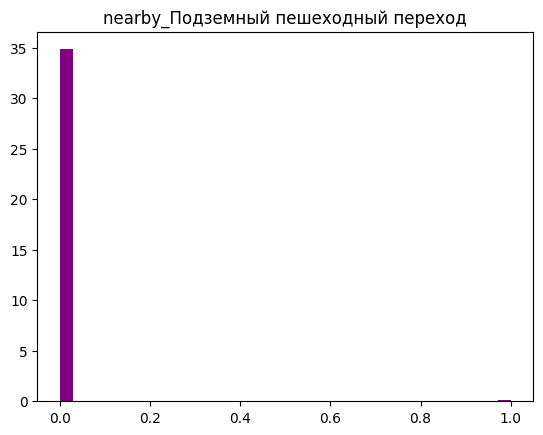

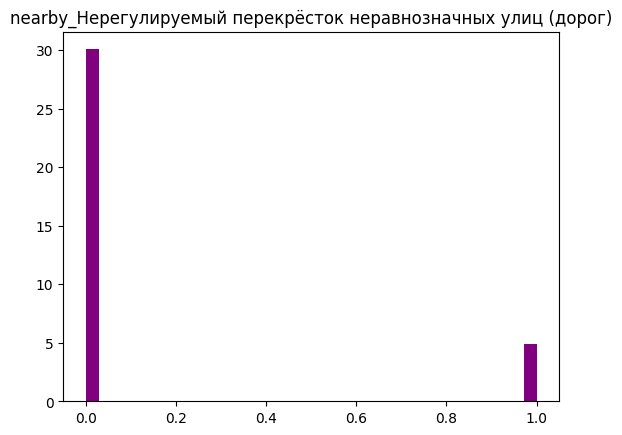

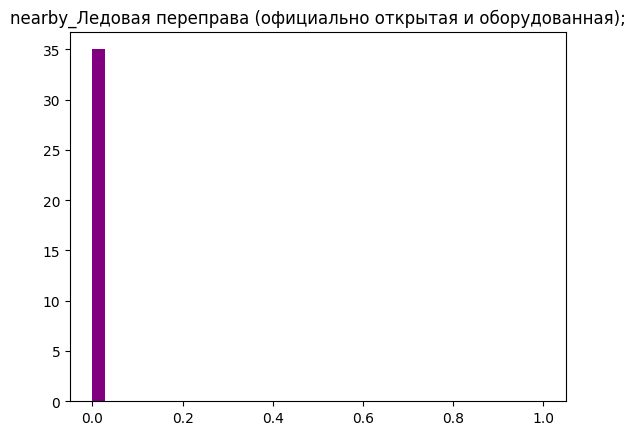

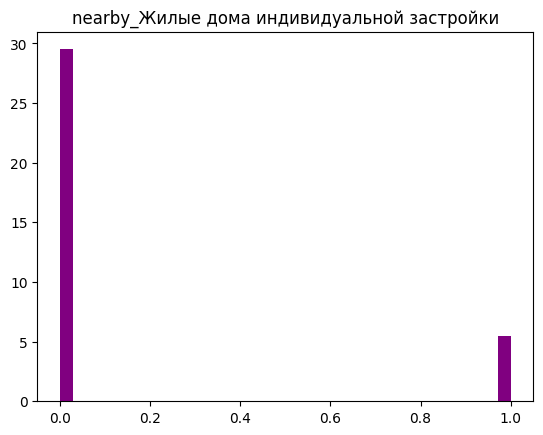

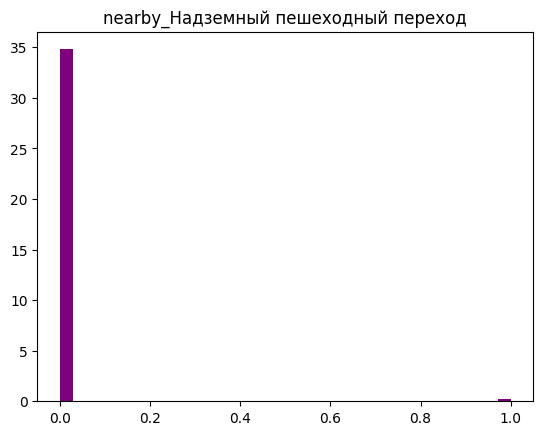

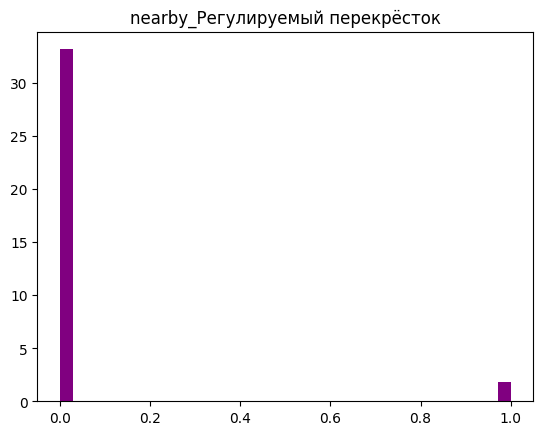

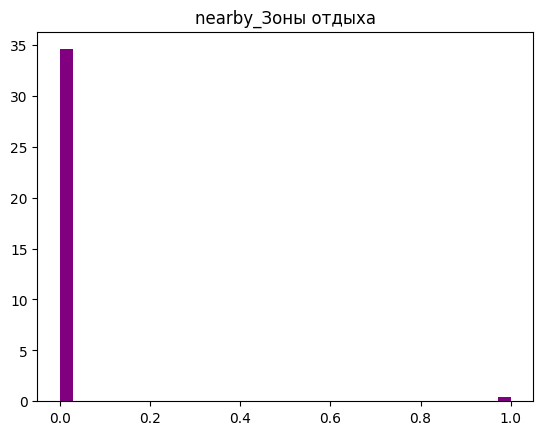

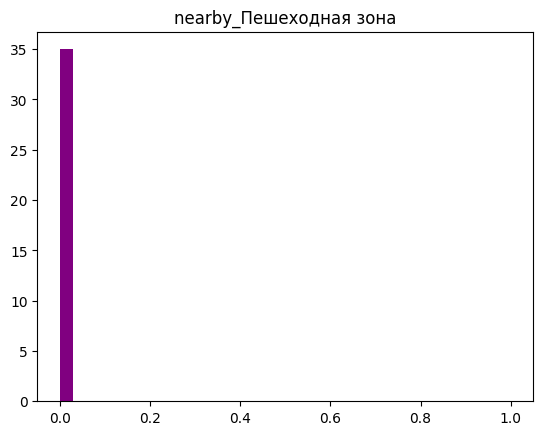

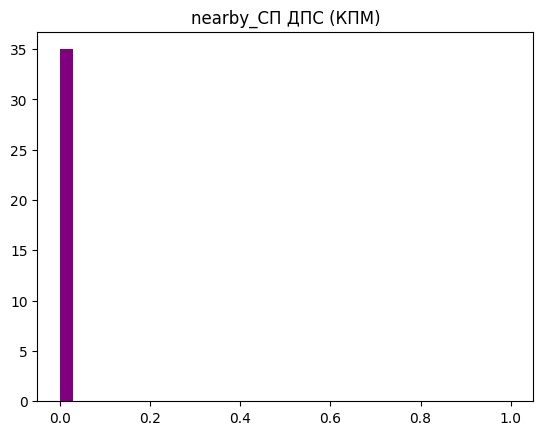

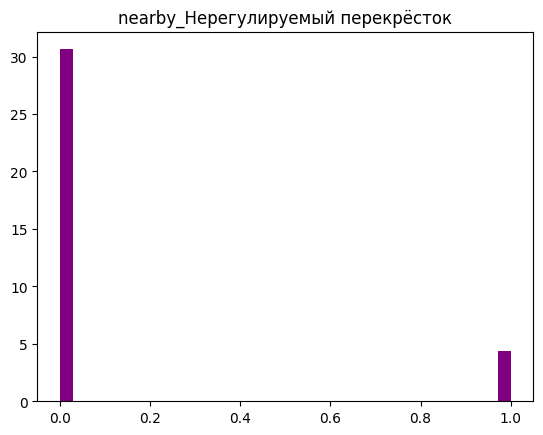

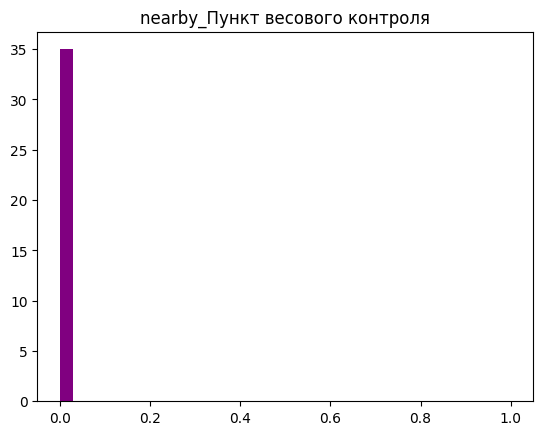

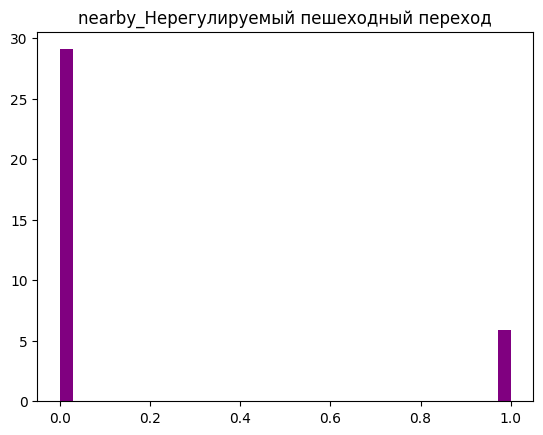

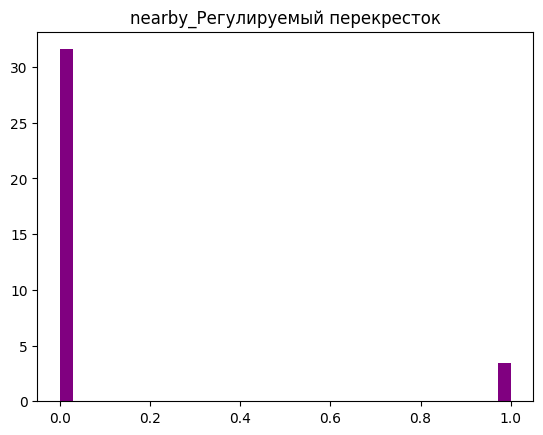

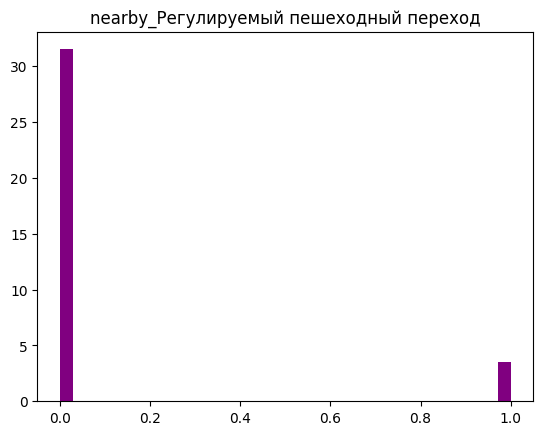

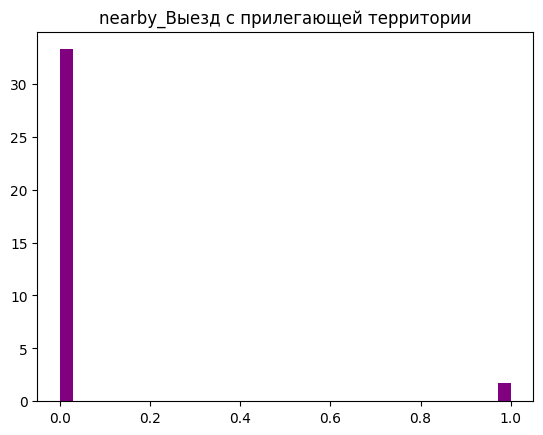

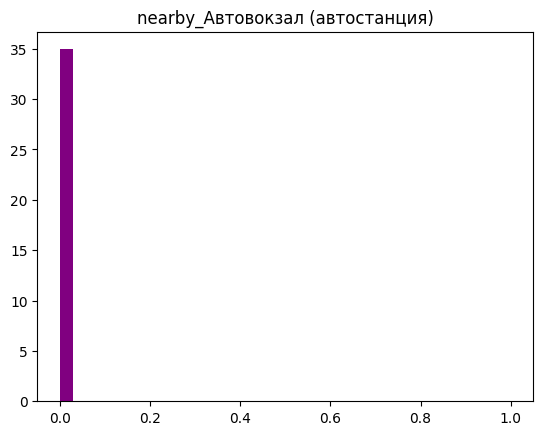

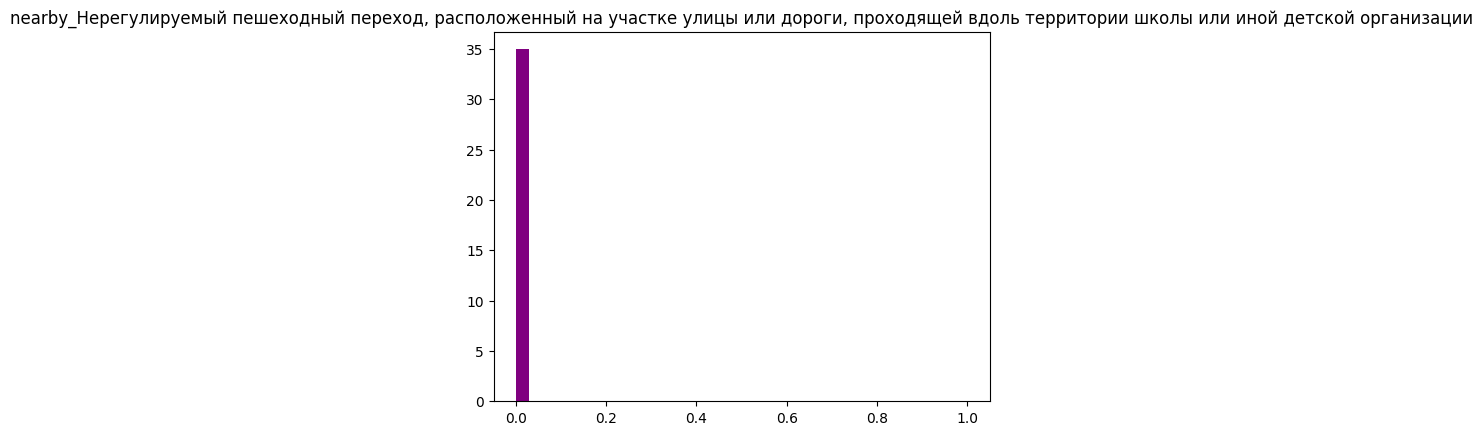

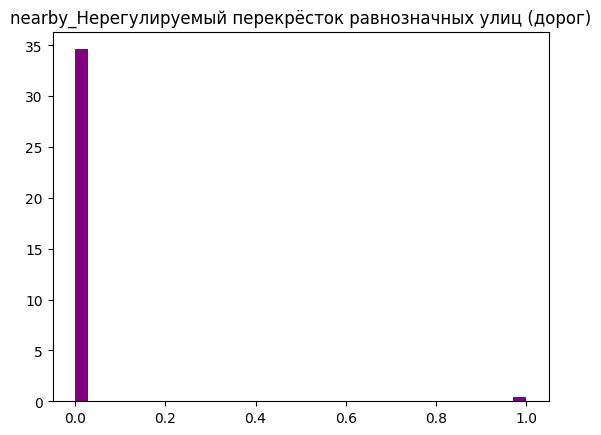

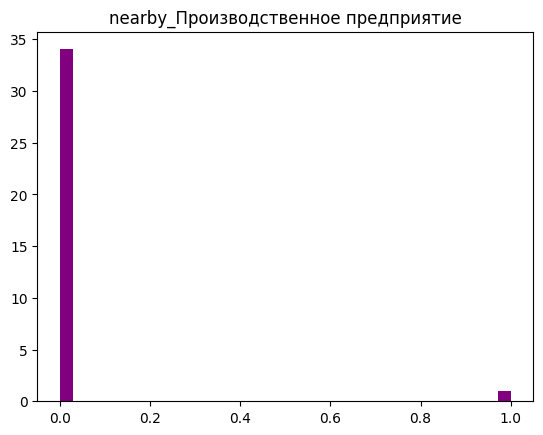

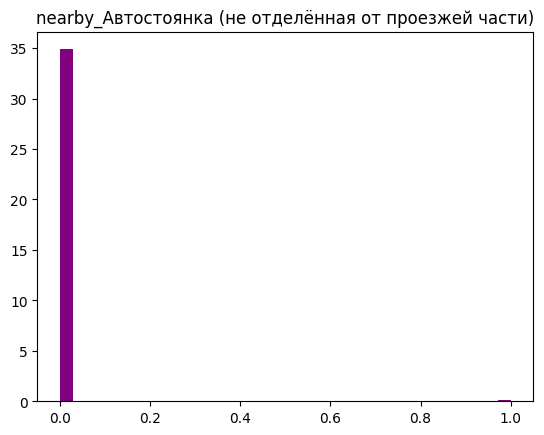

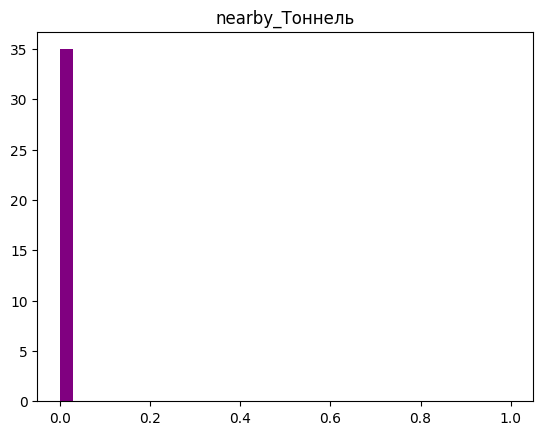

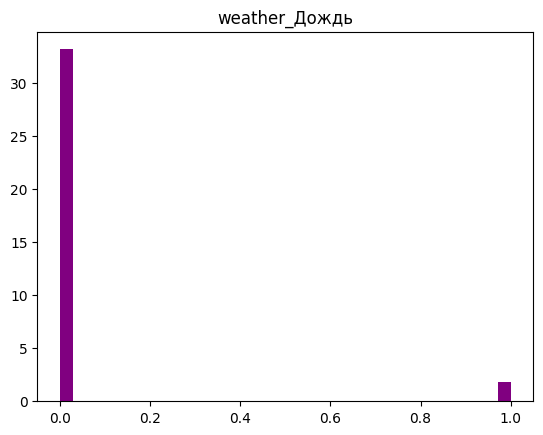

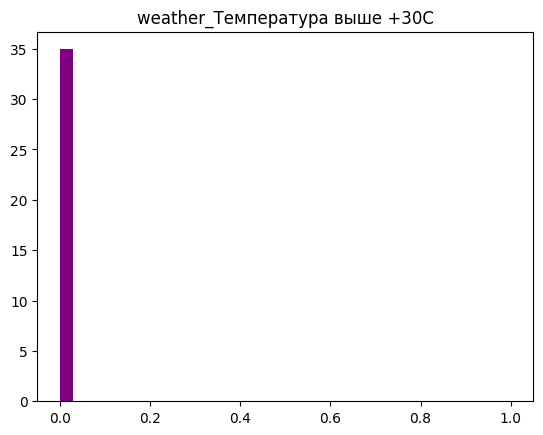

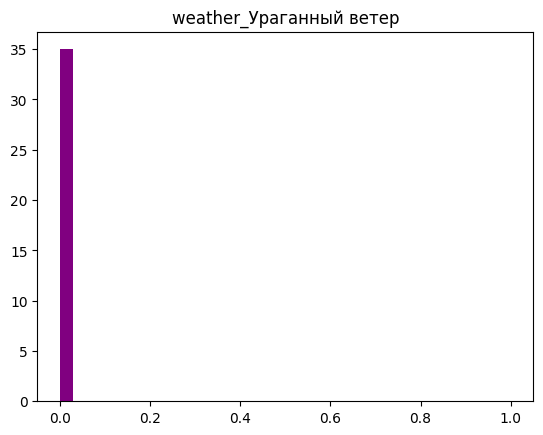

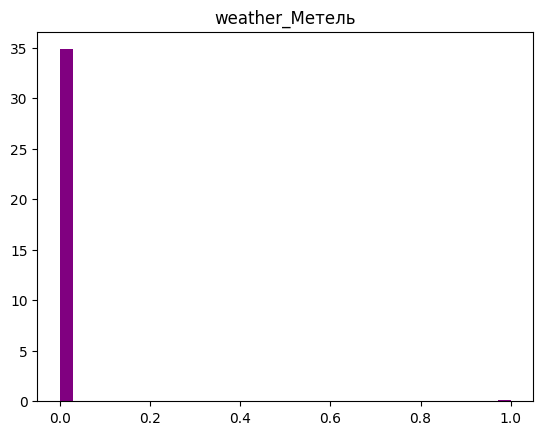

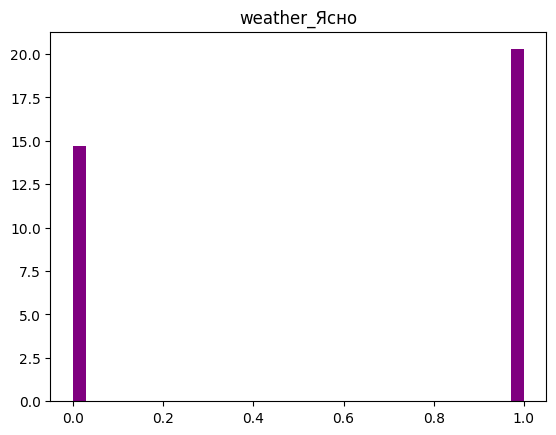

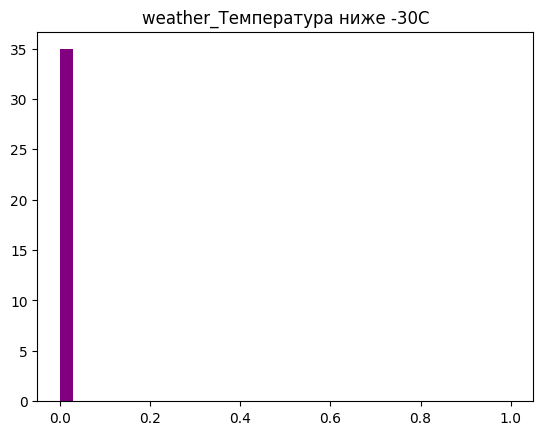

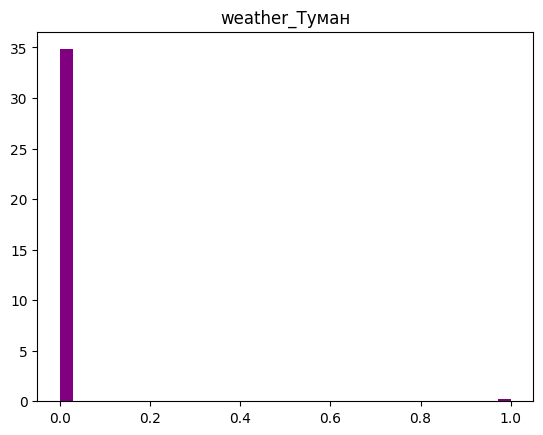

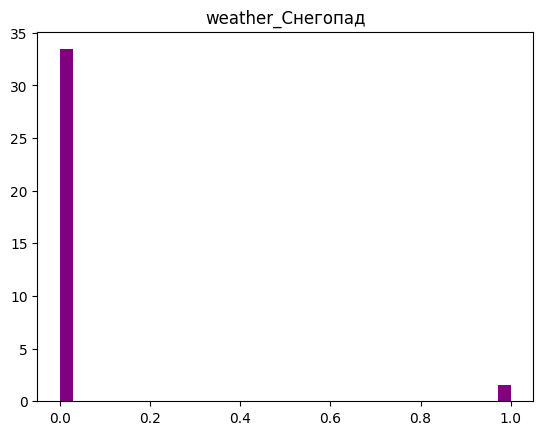

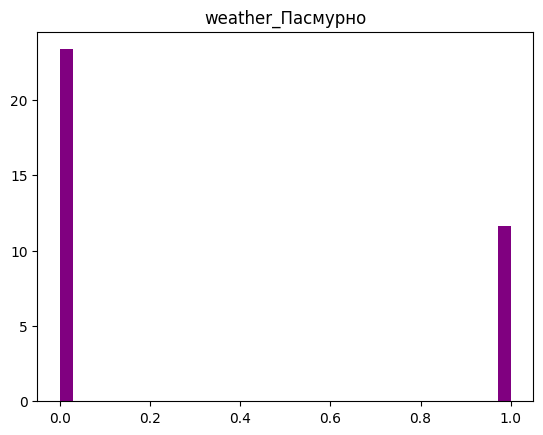

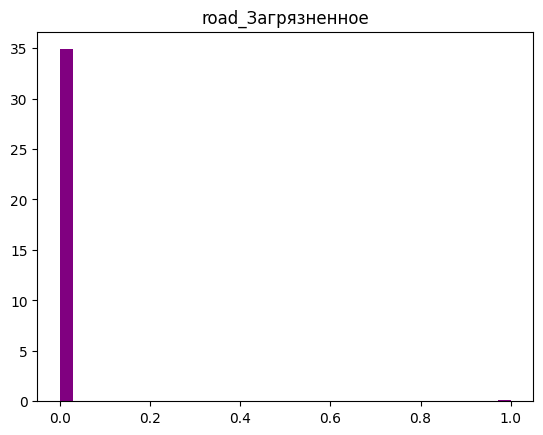

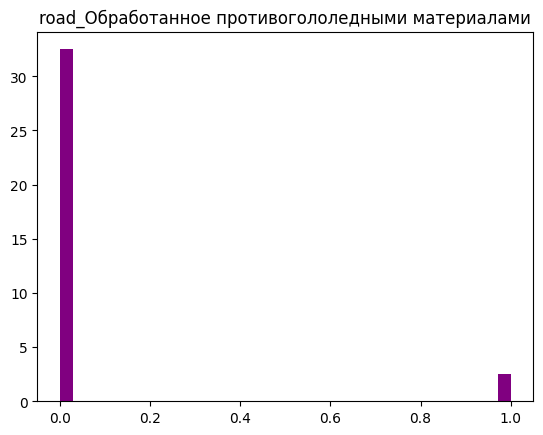

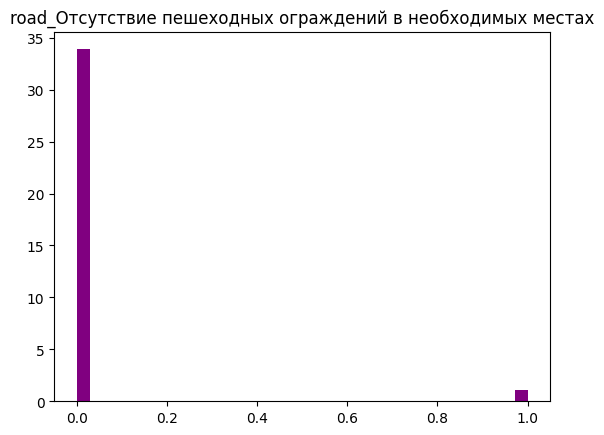

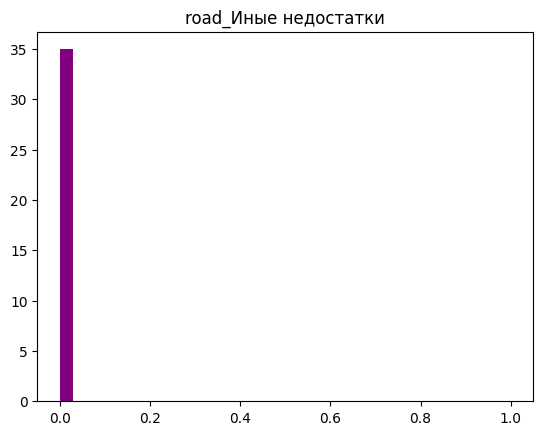

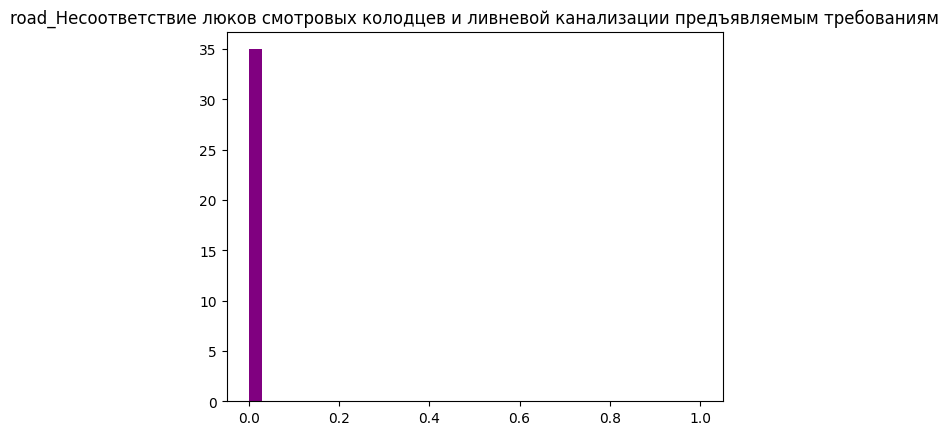

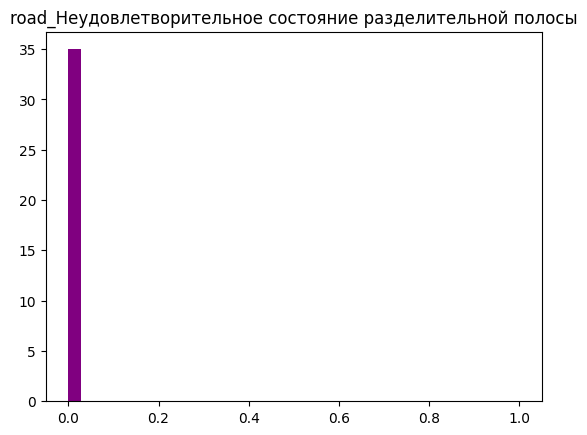

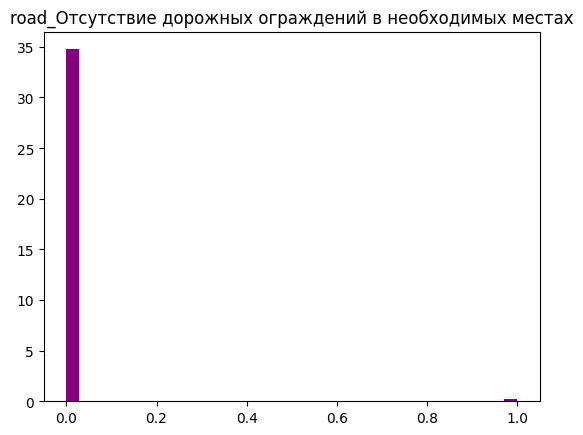

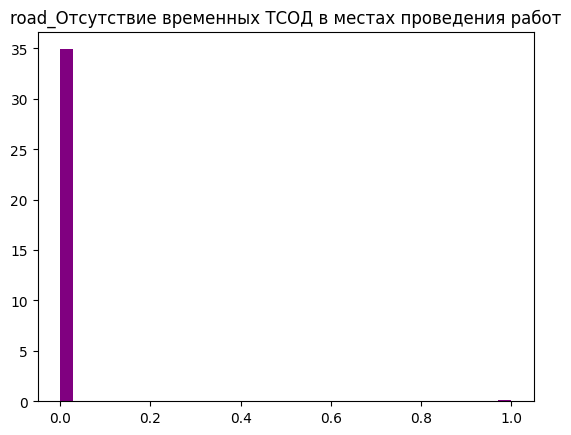

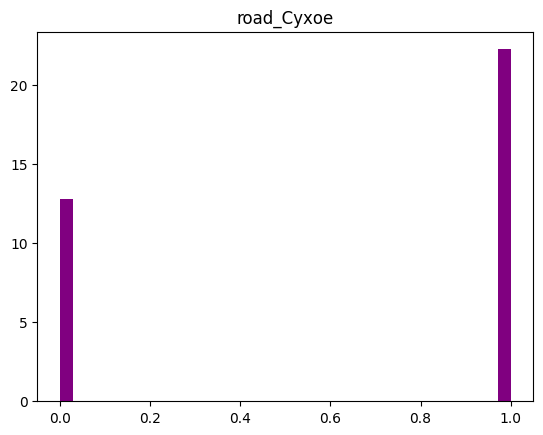

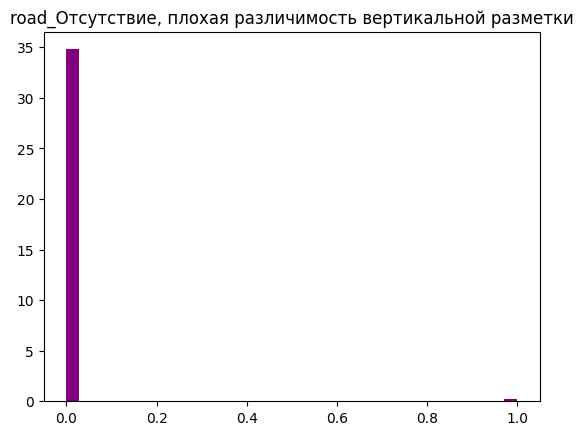

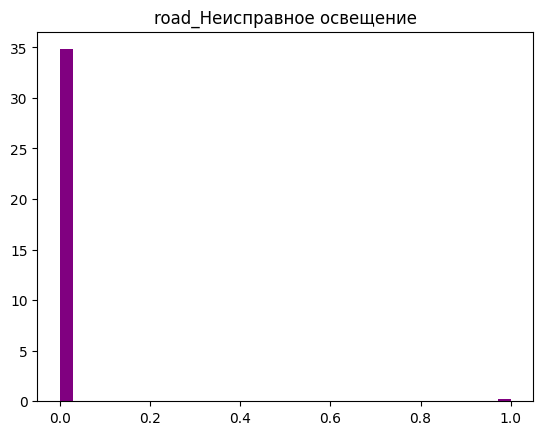

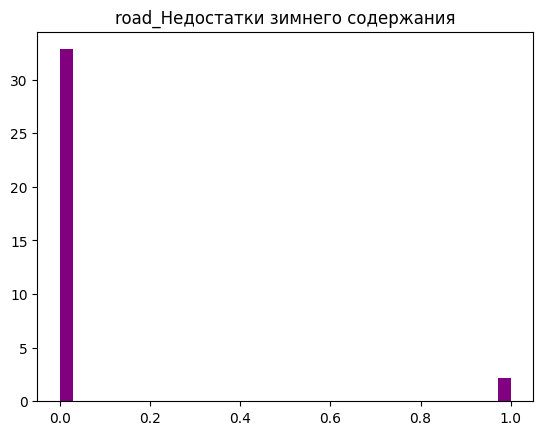

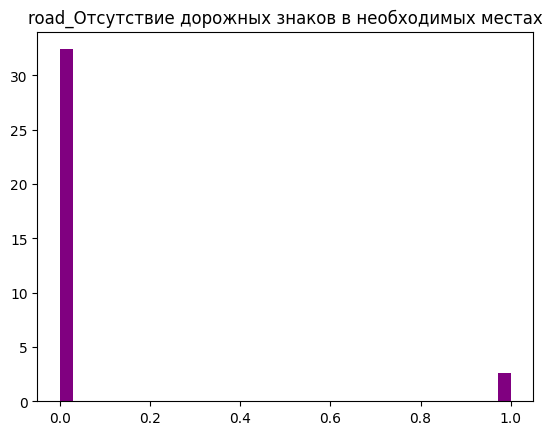

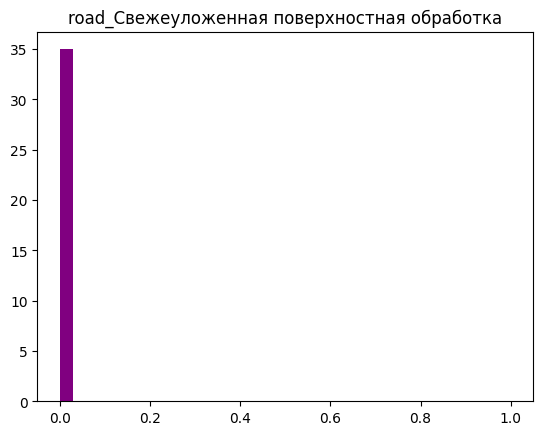

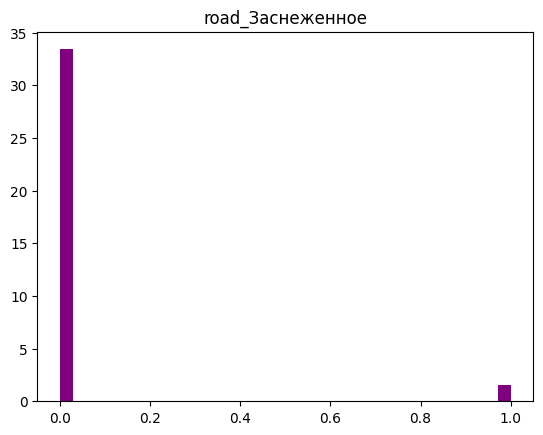

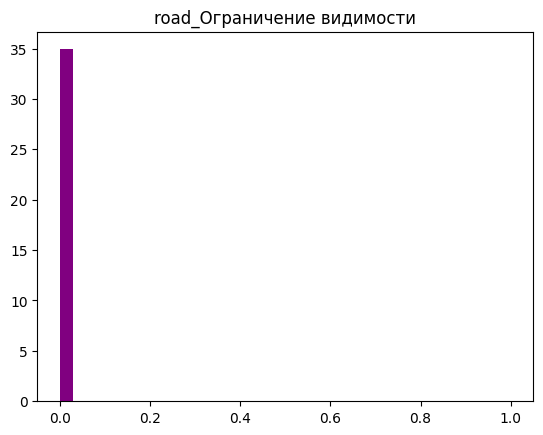

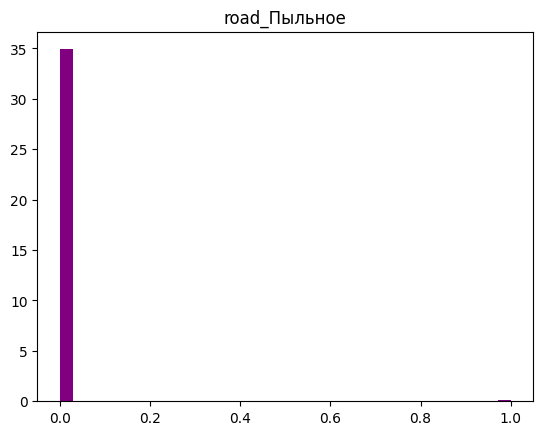

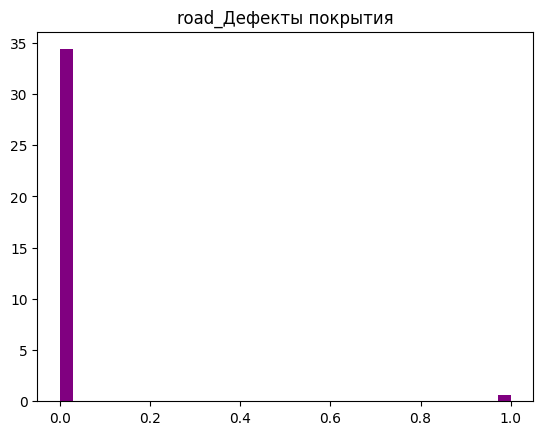

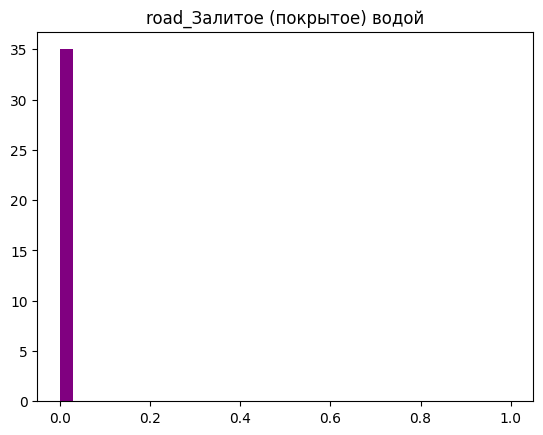

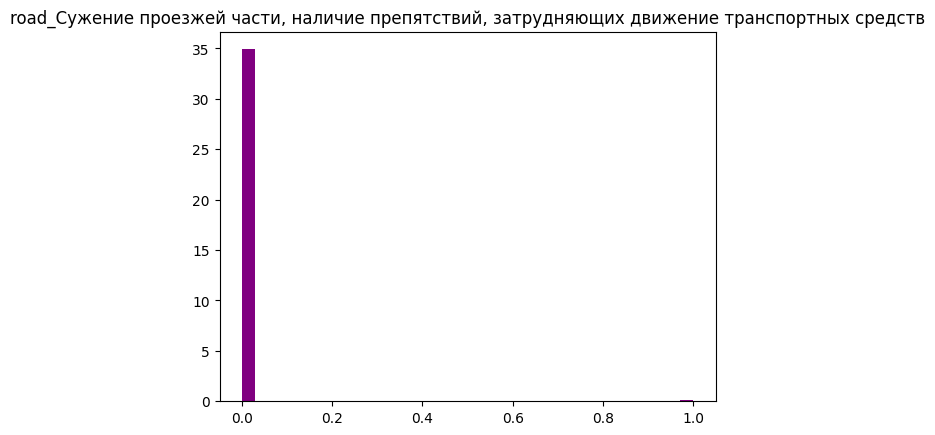

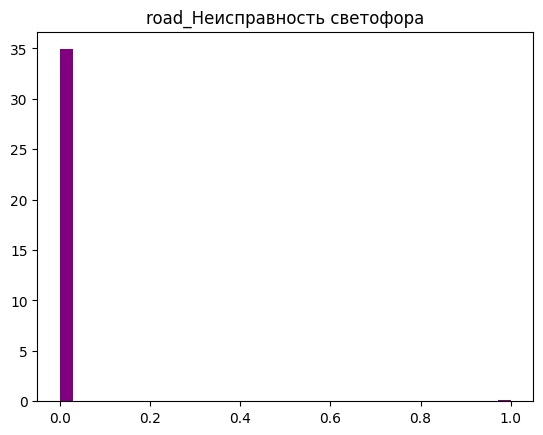

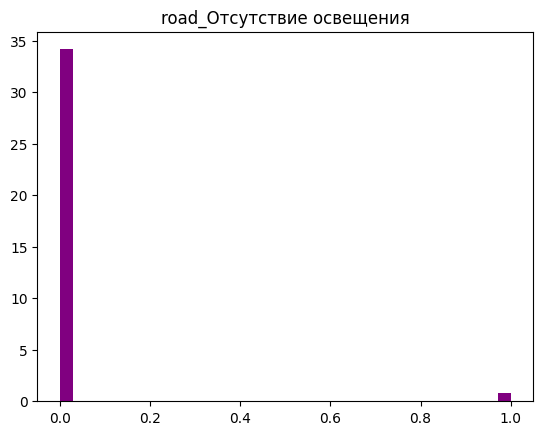

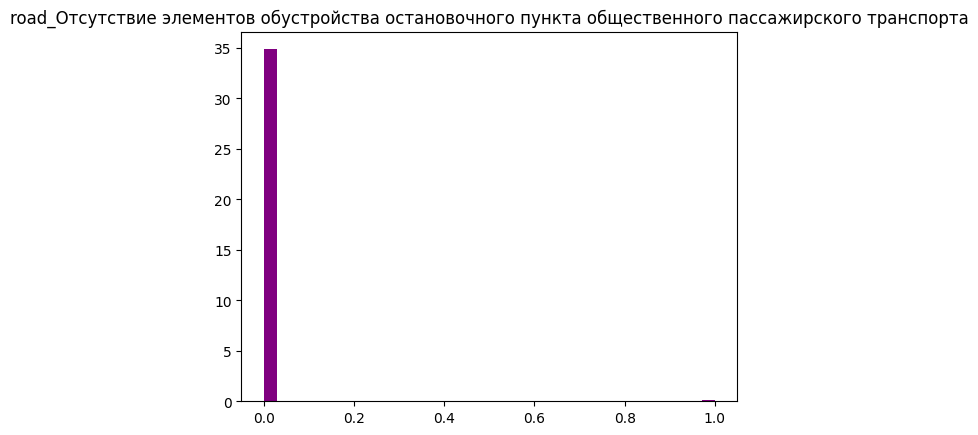

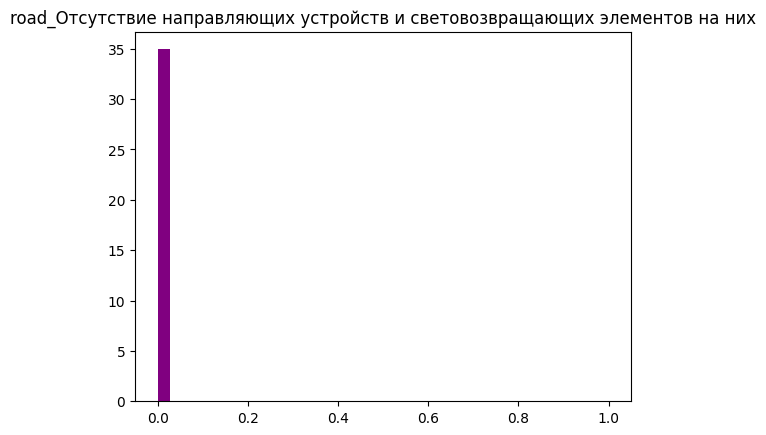

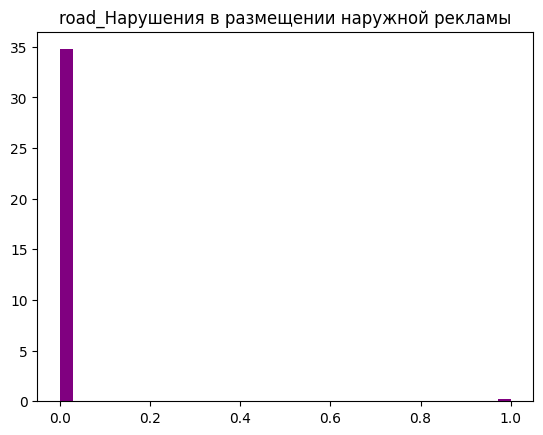

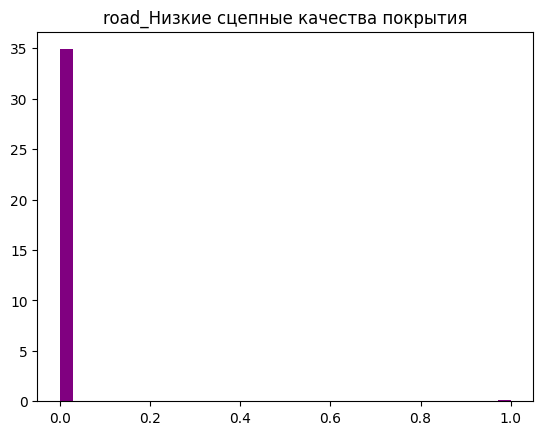

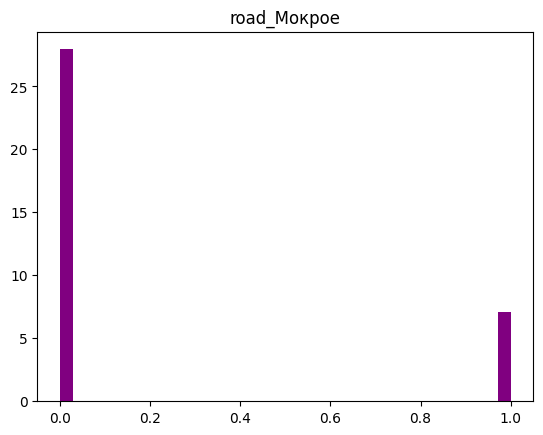

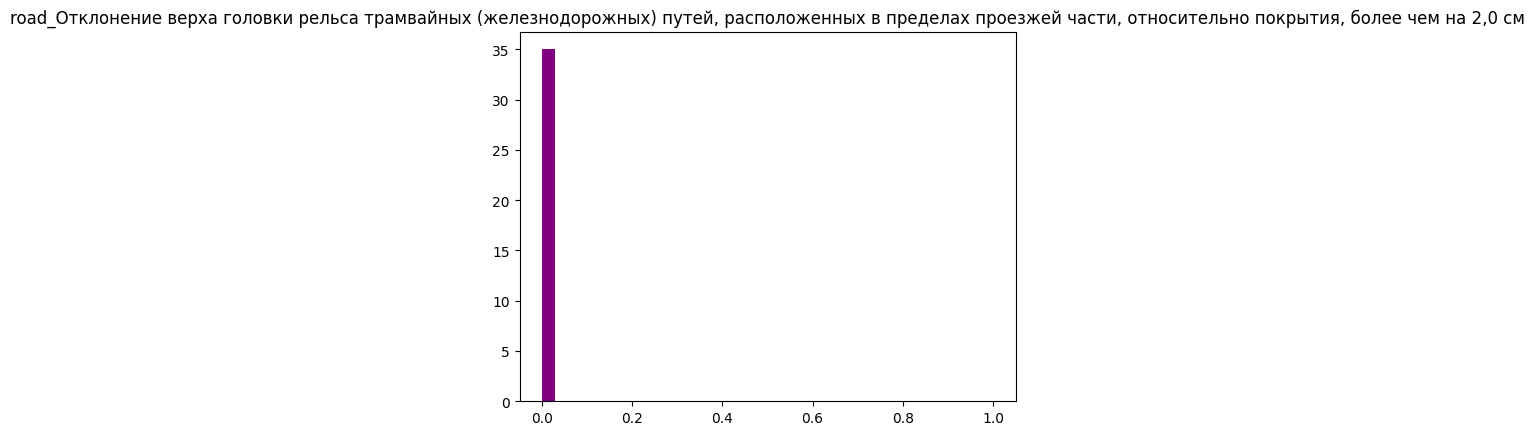

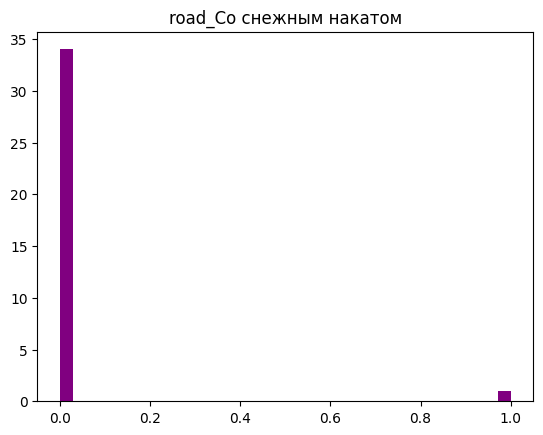

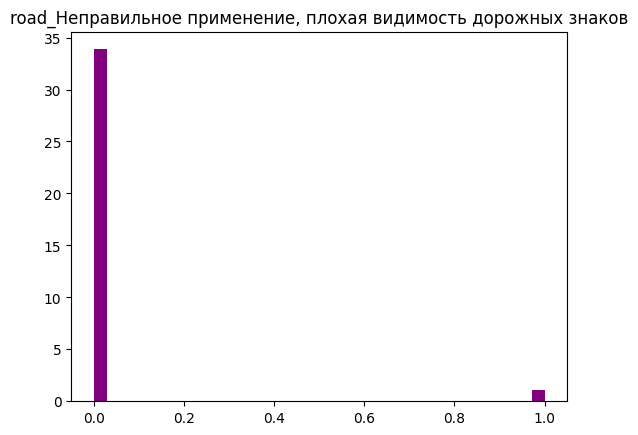

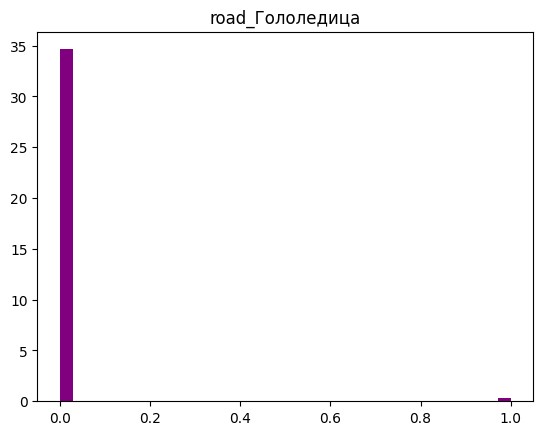

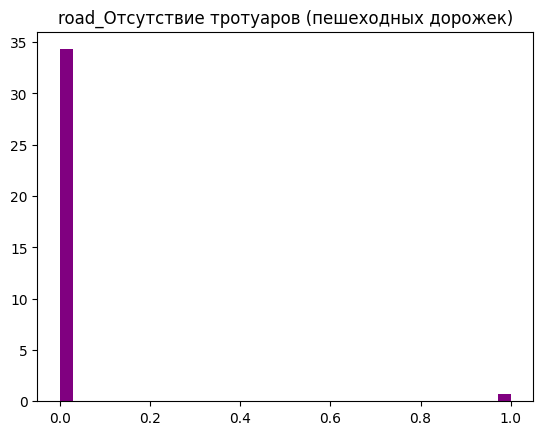

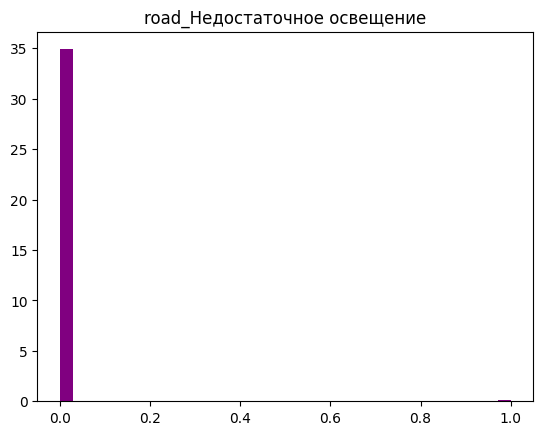

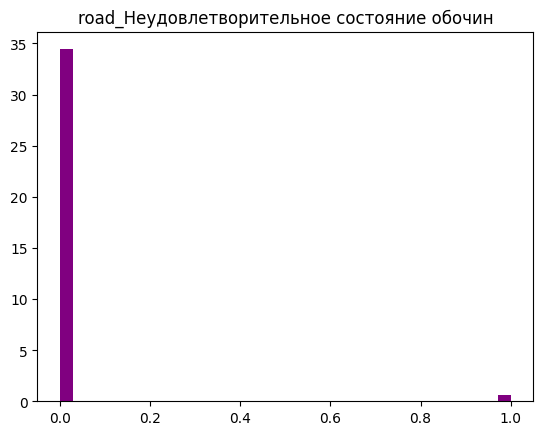

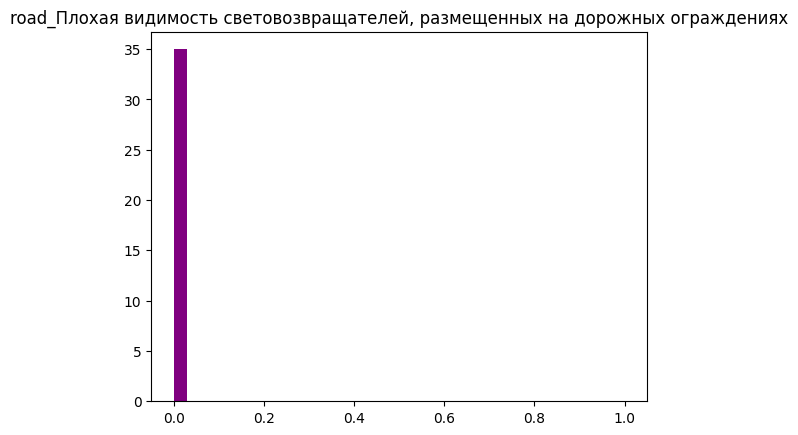

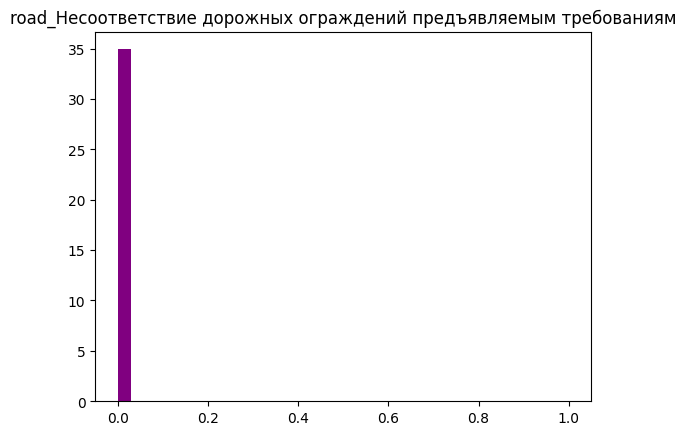

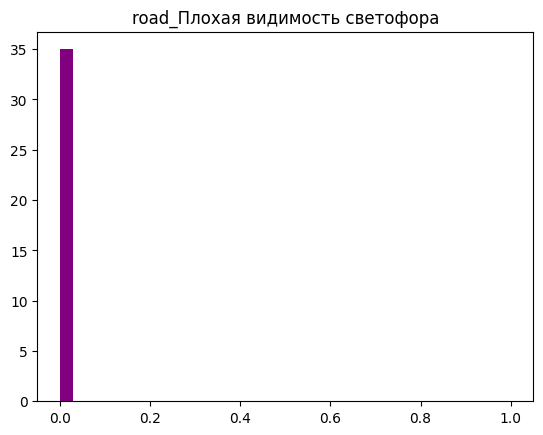

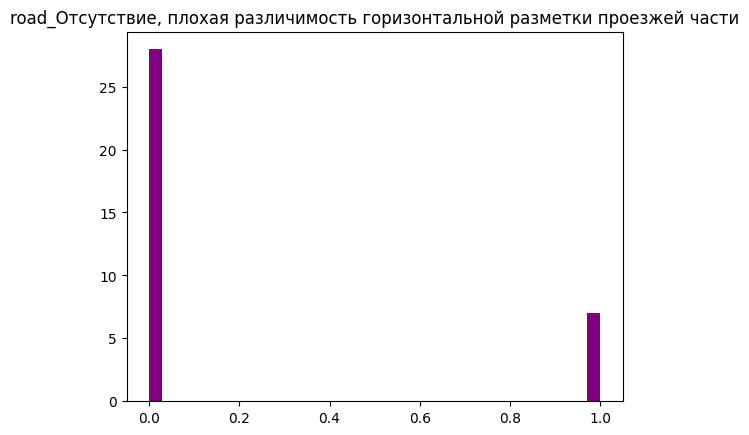

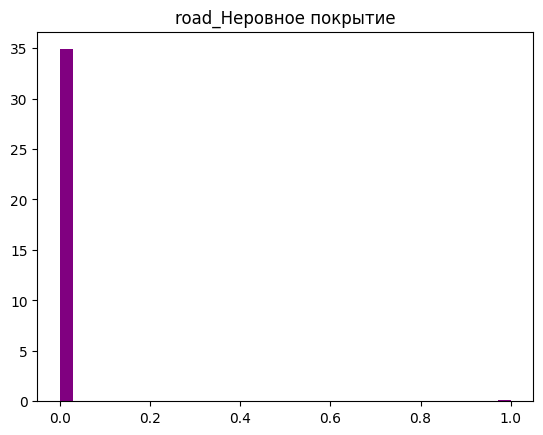

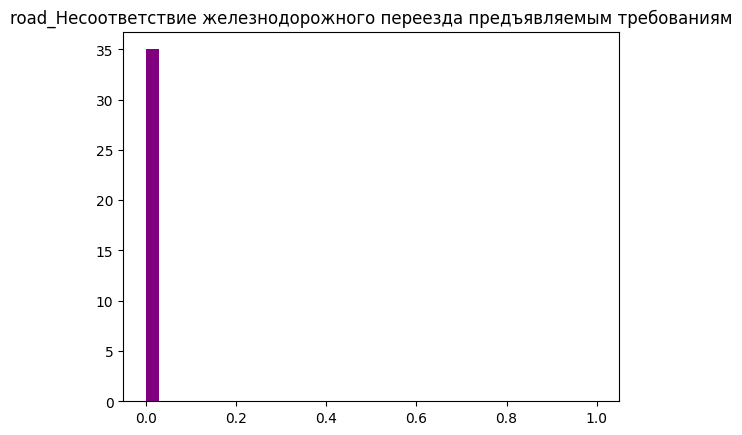

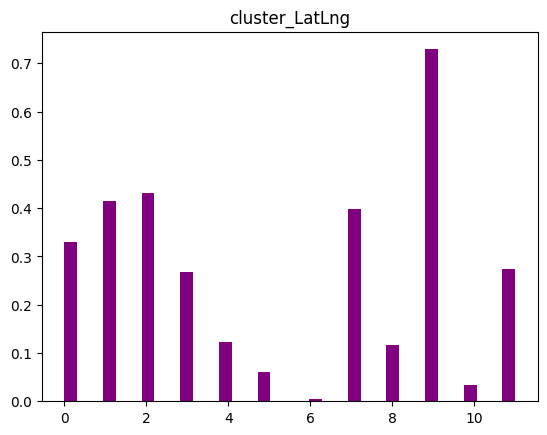

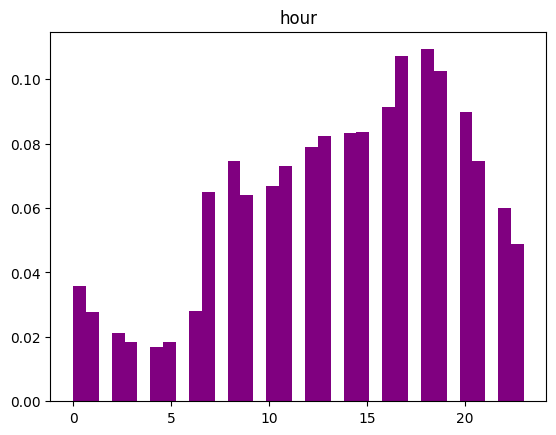

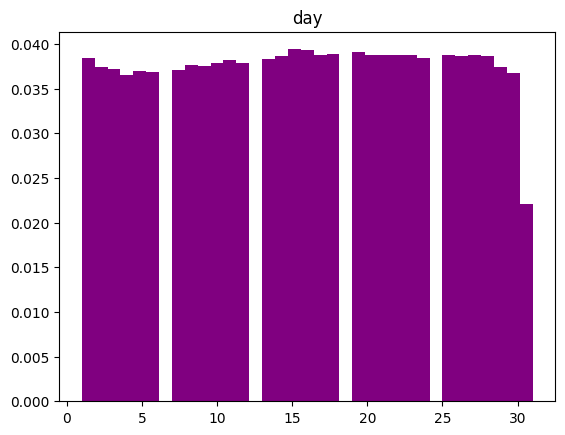

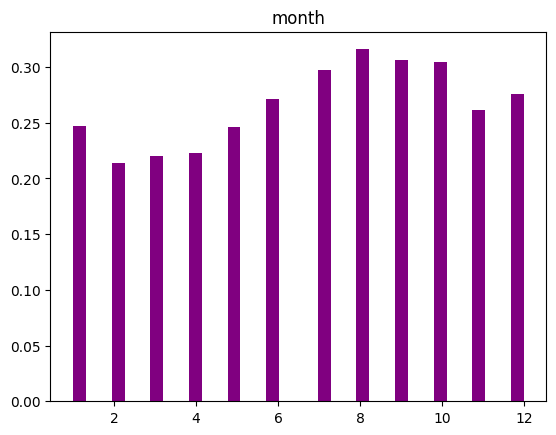

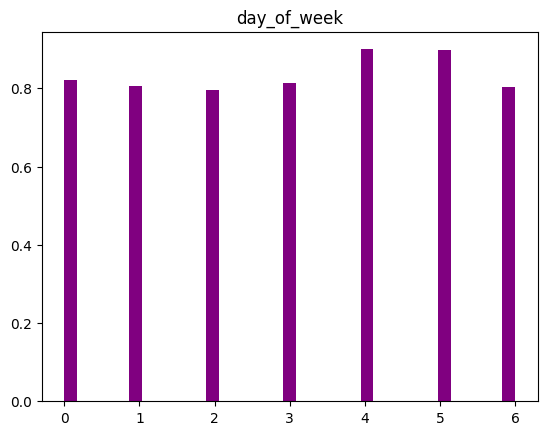

In [59]:
# визуализируем распределения атрибутов
for col in all_regions.columns:
    # за исключением вспомогательных районов
    if col not in ['parent_region', 'lat', 'long', 'geometry']:
        plt.title(col)
        plt.hist(all_regions[col], density=True, 
                bins=35, color='purple')
        plt.show();

## 1.4 Формирование дополнительных атрибутов
В представленных данных по некоторым адресам происходило несколько дорожно-транспортных происшествий. Для каждого такого адреса необходимо вычислить индекс, отражающий зависимость от количества происшествий, частоты их происхождения, тяжести последствий, доли по отношению ко всем происшествиям в регионе.

Предположим, что мы можем вычислить этот индекс по следующей формуле:

$$(1)\ \  индекс\_опасности = количество\_ДТП \cdot частота\_происхождения \cdot тяжесть\_последствий \cdot  доля\_в\_регионе $$

При этом:
$$(2)\ \  частота\_происхождения = \frac{количество\_ДТП}{12 месяцев};$$

$$(3)\ \  доля\_в\_регионе = \frac{количество\_ДТП}{общее\_количество\_ДТП_\_в\_регионе};$$

Подставив формулы (2) и (3) в формулу (1), получим:

$$(4)\ \  индекс\_опасности = \frac{(количество\_ДТП)^3 \cdot тяжесть\_последствий}{12 месяцев \cdot общее\_количество\_ДТП_\_в\_регионе}.$$

Высокие значения индекса будут говорить о том, что в месяц происходят много ДТП с высокой тяжестью урона пострадавшим. И, наоборот, низкие значения будут говорить о том, что в этой точке происходит мало ДТП с низкой тяжестью урона.

In [60]:
# используем колонку geometry в качестве уникальных адресов
len(all_regions['geometry'].unique())

954475

In [61]:
# рассчитать количество происшествий для каждой точки
accidents_count = all_regions.groupby(['geometry'])['severity'].count().reset_index()
all_regions = pd.merge(all_regions, accidents_count, on='geometry', suffixes=('', '_accidents_count'))

In [62]:
all_regions.columns

Index(['severity', 'parent_region', 'datetime', 'light', 'geometry',
       'nearby_Регулируемый ж/д переезд без дежурного',
       'nearby_Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения',
       'nearby_Ледовая переправа(официально открытая и оборудованная)',
       'nearby_Тротуар, пешеходная дорожка',
       'nearby_Мост, эстакада, путепровод',
       ...
       'road_Плохая видимость светофора',
       'road_Отсутствие, плохая различимость горизонтальной разметки проезжей части',
       'road_Неровное покрытие',
       'road_Несоответствие железнодорожного переезда предъявляемым требованиям',
       'cluster_LatLng', 'hour', 'day', 'month', 'day_of_week',
       'severity_accidents_count'],
      dtype='object', length=121)

In [63]:
# рассчитать общее количество ДТП в месяц для каждого региона
all_regions['year'] = all_regions['datetime'].dt.year
accidents_region_count = \
        all_regions.groupby(['parent_region', 
                             'year', 'month'])['severity'].count().reset_index()
all_regions = pd.merge(all_regions, accidents_region_count, 
                      on=['parent_region',  'year', 'month'], suffixes=('', '_accidents_region_count'))

In [64]:
all_regions.columns

Index(['severity', 'parent_region', 'datetime', 'light', 'geometry',
       'nearby_Регулируемый ж/д переезд без дежурного',
       'nearby_Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения',
       'nearby_Ледовая переправа(официально открытая и оборудованная)',
       'nearby_Тротуар, пешеходная дорожка',
       'nearby_Мост, эстакада, путепровод',
       ...
       'road_Неровное покрытие',
       'road_Несоответствие железнодорожного переезда предъявляемым требованиям',
       'cluster_LatLng', 'hour', 'day', 'month', 'day_of_week',
       'severity_accidents_count', 'year', 'severity_accidents_region_count'],
      dtype='object', length=123)

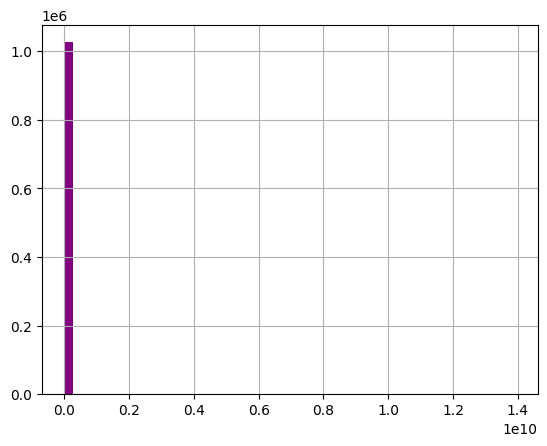

In [65]:
all_regions['hazard_index'] = ((all_regions['severity_accidents_count'] ** 3) * all_regions['severity'])\
                                            / (12 *  all_regions['severity_accidents_region_count'])
all_regions['hazard_index'].hist(bins=50, color='purple');

Видим, что порядка 1 000 000 точек имеют почти нулевой или нулевой индекс опасности. Пусть значения нашего нового атрибута будут находиться в диапазоне $[0;1]$. Посмотрим на распределение значений нового атрибута, которые оказались аномально выше единицы.

In [66]:
all_regions[(all_regions['hazard_index'] > 1)].shape[0] / len(all_regions) * 100

6.1476534359255774

Записей с аномально высоким показателем индекса не так много, их можно отбросить.

In [67]:
all_regions.drop(index=all_regions[(all_regions['hazard_index'] > 1)].index, inplace=True)

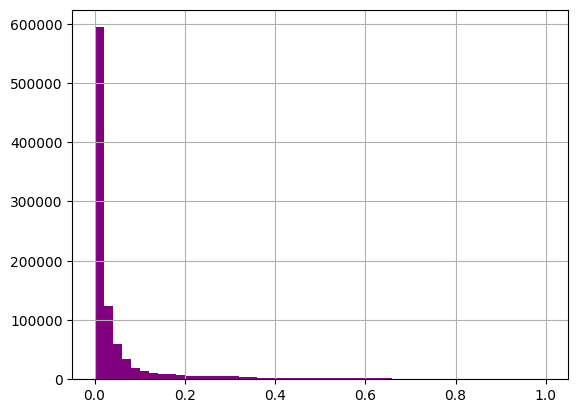

In [68]:
all_regions['hazard_index'].hist(bins=50, color='purple');

Попробуем разделить наши данные на несколько групп по значению нового атрибута при помощи кластеризации. Таким образом, мы даже сможем сохранить зависимости внутри набора данных.

In [69]:
# удалим ненужные признаки
all_regions.drop(columns=['severity_accidents_count',
                          'severity_accidents_region_count', 'datetime',
                          'parent_region', 'geometry', 'severity'], inplace=True)

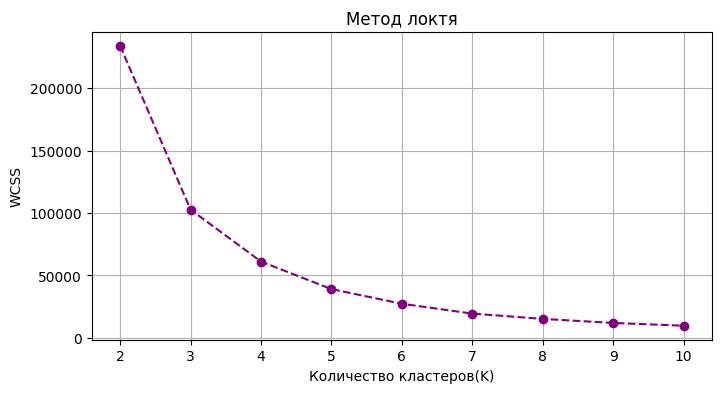

In [70]:
X_scaled = StandardScaler().fit_transform(all_regions[['hazard_index']])
inertia = [] 
max_clusters = 10  
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=2023)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, max_clusters + 1), inertia, marker='o', linestyle='--', color='purple')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров(K)')
plt.ylabel('WCSS')
plt.grid()
plt.show();

Можно заметить, что оптимальным числом кластеров оказалось 4. Сгруппируем наши данные в 4 класса и посмотрим на распределение индекса опасности в каждой группе.

In [71]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X_scaled)
all_regions['danger_class'] = clusters

In [72]:
all_regions['danger_class'].value_counts(normalize=True)

2    0.853560
0    0.084236
3    0.040798
1    0.021405
Name: danger_class, dtype: float64

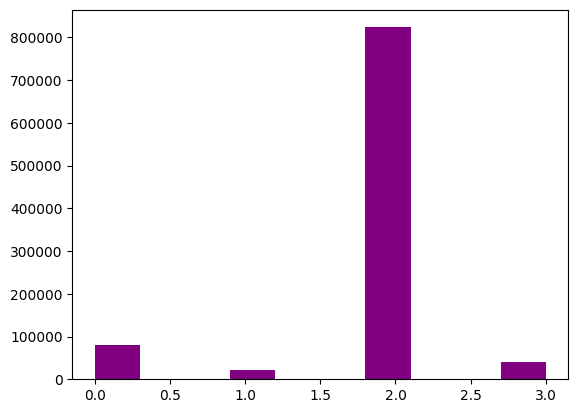

In [73]:
all_regions['danger_class'].hist(color='purple');
plt.grid(False)

Рассмотрим распределение индекса опасности точки на карте для каждого класса.

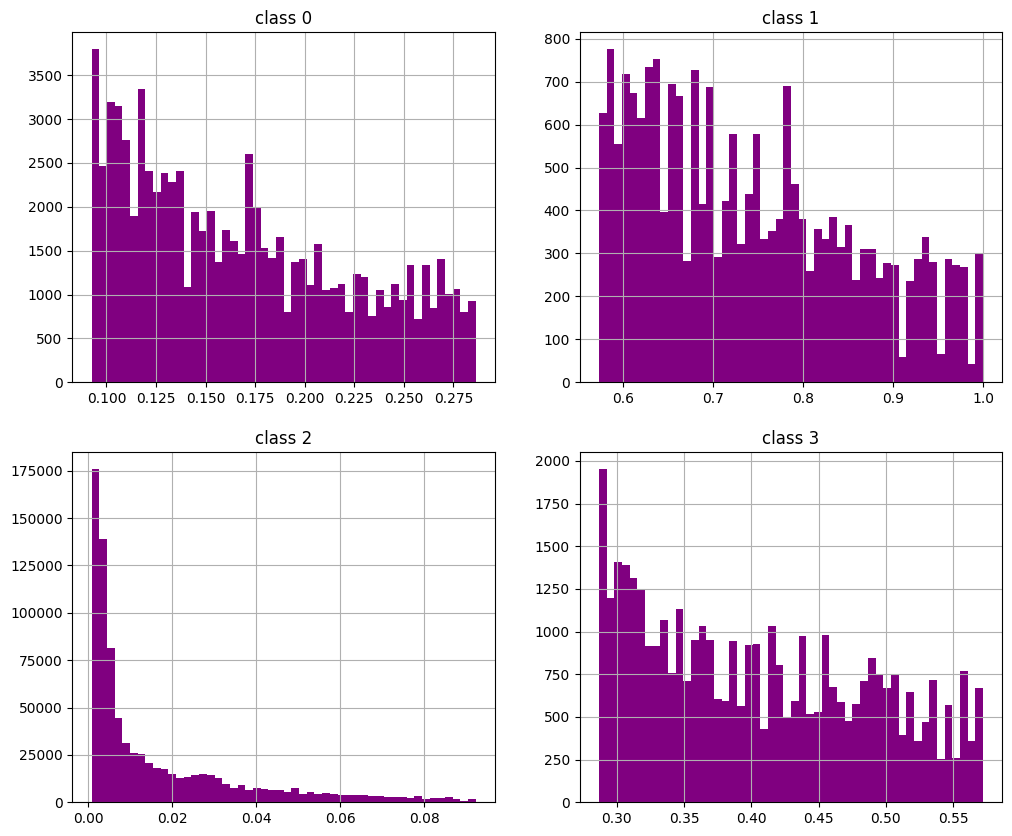

In [74]:
plt.figure(figsize=[12, 10])
for danger_class in range(0, 4):
    plt.subplot(2, 2, danger_class+1)
    plt.title(f"class {danger_class}")
    all_regions[all_regions['danger_class']== danger_class]\
                    ['hazard_index'].hist(bins=50, color='purple')
    
plt.show();

Исходя из представленных графиков, можно увидеть, что значения индекса выстроились в единую шкалу:
* класс 2 (значения индекса в диапазоне [0; 0.09], 85% всей вероятностной массы) - это участки с очень низкой вероятностью возникновения происшествия, место случайной аварии;
* класс 0 (значения индекса в диапазоне (0.09; 0.28], 8% всех объектов) - участки с низкой вероятностью возникновения повторного ДТП, "зелёный" уровень;
* класс 3 (значения (0.28; 0.58], 4% всех объектов) - участки с повышенной опасностью, "жёлтый" уровень опасности;
* класс 1 (значения (0.58; 1], 2% всех объектов) - участки с высокой частотой происшествий, "красный" уровень опасности, обращать внимание на эти точки на карте необходимо в первую очередь.

## Итог
Во время выполнения заданий первого модуля были получены данные из файлов формата geojson, данные были объединены в одну структуру и предобработаны. Предобработка рассмотренного набора данных включала в себя удаление сложных, составных структур внутри атрибутов, преобразование типов данных отдельных атрибутов и выделение новых атрибутов, один из которых должен стать целевым для задачи классификации в модуле 2. Итогом проделанной работы стали преобработанные и проанализированные данные.

In [75]:
all_regions.drop(columns=['hazard_index'], inplace=True)

In [76]:
all_regions.to_csv('data/all_regions.csv', index=False)
all_regions.head(5)

,light,nearby_Регулируемый ж/д переезд без дежурного,"nearby_Нерегулируемый пешеходный переход, расположенный на участке улицы или дороги, проходящей вдоль территории школы или иного детского учреждения",nearby_Ледовая переправа(официально открытая и оборудованная),"nearby_Тротуар, пешеходная дорожка","nearby_Мост, эстакада, путепровод",nearby_Нерегулируемый ж/д переезд,nearby_Место для перегона скота,nearby_Остановка общественного транспорта,nearby_Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта),...,"road_Отсутствие, плохая различимость горизонтальной разметки проезжей части",road_Неровное покрытие,road_Несоответствие железнодорожного переезда предъявляемым требованиям,cluster_LatLng,hour,day,month,day_of_week,year,danger_class
2,10,0,0,0,0,0,0,0,0,0,...,0,1,0,8,23,12,10,0,2015,2
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,18,10,6,2015,2
4,6,0,0,0,0,0,0,0,0,0,...,1,0,0,8,21,3,10,5,2015,2
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,8,15,25,10,6,2015,1
6,10,0,0,0,0,0,0,0,0,0,...,0,0,0,8,20,23,10,4,2015,2


In [77]:
all_regions.shape

(964575, 118)